In [1]:
# import normal libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# import models
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier

# import libraries for hyperparameter tuning
import optuna
import time
import os
import sys
import gc

In [2]:
# Get data
data1 = pd.read_csv("preprocessed_data/dataset_feat_eng.csv")
data2 = pd.read_csv("preprocessed_data/dataset_smote_balanced.csv")

# Get head
display(data1.head())
display(data2.head())

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nationality,Mother's qualification,Father's qualification,Mother's occupation,...,Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target,Success_rate_1st_sem,Success_rate_2nd_sem,Success_rate_overall,Grade_change
0,1,8,5,2,1,1,1,13,10,6,...,0.000000,0,10.8,1.4,1.74,Dropout,0.000000,0.000000,0.000000,0.000000
1,1,6,1,11,1,1,1,1,3,4,...,13.666667,0,13.9,-0.3,0.79,Graduate,1.000000,1.000000,1.000000,-0.333333
2,1,1,5,5,1,1,1,22,27,10,...,0.000000,0,10.8,1.4,1.74,Dropout,0.000000,0.000000,0.000000,0.000000
3,1,8,2,15,1,1,1,23,27,6,...,12.400000,0,9.4,-0.8,-3.12,Graduate,1.000000,0.833333,0.916667,-1.028571
4,2,12,1,3,0,1,1,22,28,10,...,13.000000,0,13.9,-0.3,0.79,Graduate,0.833333,1.000000,0.916667,0.666667


,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nationality,Mother's qualification,Father's qualification,Mother's occupation,...,Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Success_rate_1st_sem,Success_rate_2nd_sem,Success_rate_overall,Grade_change,Target
0,1,8,5,2,1,1,1,13,10,6,...,0.000000,0,10.8,1.4,1.74,0.000000,0.000000,0.000000,0.000000,Dropout
1,1,6,1,11,1,1,1,1,3,4,...,13.666667,0,13.9,-0.3,0.79,1.000000,1.000000,1.000000,-0.333333,Graduate
2,1,1,5,5,1,1,1,22,27,10,...,0.000000,0,10.8,1.4,1.74,0.000000,0.000000,0.000000,0.000000,Dropout
3,1,8,2,15,1,1,1,23,27,6,...,12.400000,0,9.4,-0.8,-3.12,1.000000,0.833333,0.916667,-1.028571,Graduate
4,2,12,1,3,0,1,1,22,28,10,...,13.000000,0,13.9,-0.3,0.79,0.833333,1.000000,0.916667,0.666667,Graduate


In [3]:
# Remove "enrolled" rows from target
data3 = data1.copy()
data3 = data3[data3['Target'] != 'Enrolled']

# Check size
print("Original Data Size:", data1.shape)
print("No Enrolled Data Size:", data3.shape)

Original Data Size: (4424, 39)
No Enrolled Data Size: (3630, 39)


In [4]:
# map target
target_mapping = {
    "Dropout": 0,
    "Graduate": 1,
    "Enrolled": 2
}

# apply mapping
data1["Target"] = data1["Target"].map(target_mapping)
data2["Target"] = data2["Target"].map(target_mapping)
data3["Target"] = data3["Target"].map(target_mapping)

In [5]:
# Split data1 into features and target
X = data1.drop(columns=["Target"])
y = data1["Target"]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")
print(f"Target distribution in training set:\n{y_train.value_counts()}")
print(f"Target distribution in test set:\n{y_test.value_counts()}")

Training set size: (3539, 38)
Test set size: (885, 38)
Target distribution in training set:
Target
1    1767
0    1137
2     635
Name: count, dtype: int64
Target distribution in test set:
Target
1    442
0    284
2    159
Name: count, dtype: int64


In [6]:
# Split data2 into features and target
X_bal = data2.drop(columns=["Target"])
y_bal = data2["Target"]

# Split into train and test sets
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_bal, y_bal, test_size=0.2, random_state=42, stratify=y_bal)

print(f"Balanced Training set size: {X_train_bal.shape}")
print(f"Balanced Test set size: {X_test_bal.shape}")
print(f"Balanced Target distribution in training set:\n{y_train_bal.value_counts()}")
print(f"Balanced Target distribution in test set:\n{y_test_bal.value_counts()}")

Balanced Training set size: (5301, 38)
Balanced Test set size: (1326, 38)
Balanced Target distribution in training set:
Target
1    1767
0    1767
2    1767
Name: count, dtype: int64
Balanced Target distribution in test set:
Target
1    442
2    442
0    442
Name: count, dtype: int64


In [7]:
# Split data3 into features and target
X_no_enrolled = data3.drop(columns=["Target"])
y_no_enrolled = data3["Target"]

# Split into train and test sets
X_train_no_enrolled, X_test_no_enrolled, y_train_no_enrolled, y_test_no_enrolled = train_test_split(X_no_enrolled, y_no_enrolled, test_size=0.2, random_state=42, stratify=y_no_enrolled)

print(f"No Enrolled Training set size: {X_train_no_enrolled.shape}")
print(f"No Enrolled Test set size: {X_test_no_enrolled.shape}")
print(f"No Enrolled Target distribution in training set:\n{y_train_no_enrolled.value_counts()}")
print(f"No Enrolled Target distribution in test set:\n{y_test_no_enrolled.value_counts()}")

No Enrolled Training set size: (2904, 38)
No Enrolled Test set size: (726, 38)
No Enrolled Target distribution in training set:
Target
1    1767
0    1137
Name: count, dtype: int64
No Enrolled Target distribution in test set:
Target
1    442
0    284
Name: count, dtype: int64


In [8]:
# make images directory
if not os.path.exists('images'):
    os.makedirs('images')

# LOGISTIC REGRESSION

Logistic Regression Performance on Test Set
Macro F1 Score: 0.6715478339350179
Macro Precision: 0.6973284526549132
Macro Recall: 0.6652785176295829
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.76      0.78       284
           1       0.79      0.93      0.86       442
           2       0.49      0.30      0.38       159

    accuracy                           0.76       885
   macro avg       0.70      0.67      0.67       885
weighted avg       0.74      0.76      0.75       885



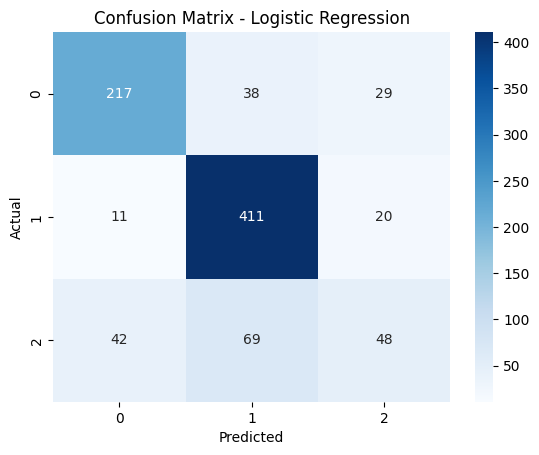

In [9]:
# Initialize model
logreg = LogisticRegression(max_iter=5000, random_state=42)

# Fit model
logreg.fit(X_train, y_train)

# Predict
y_pred = logreg.predict(X_test)

# Evaluate
print("Logistic Regression Performance on Test Set")
print("Macro F1 Score:", f1_score(y_test, y_pred, average='macro'))
print("Macro Precision:", precision_score(y_test, y_pred, average='macro'))
print("Macro Recall:", recall_score(y_test, y_pred, average='macro'))
print("Classification Report:")
print(classification_report(y_test, y_pred))
# Plot confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression')
# Save confusion matrix
plt.savefig('images/confusion_matrix_logistic_regression.png', dpi=500)

plt.show()

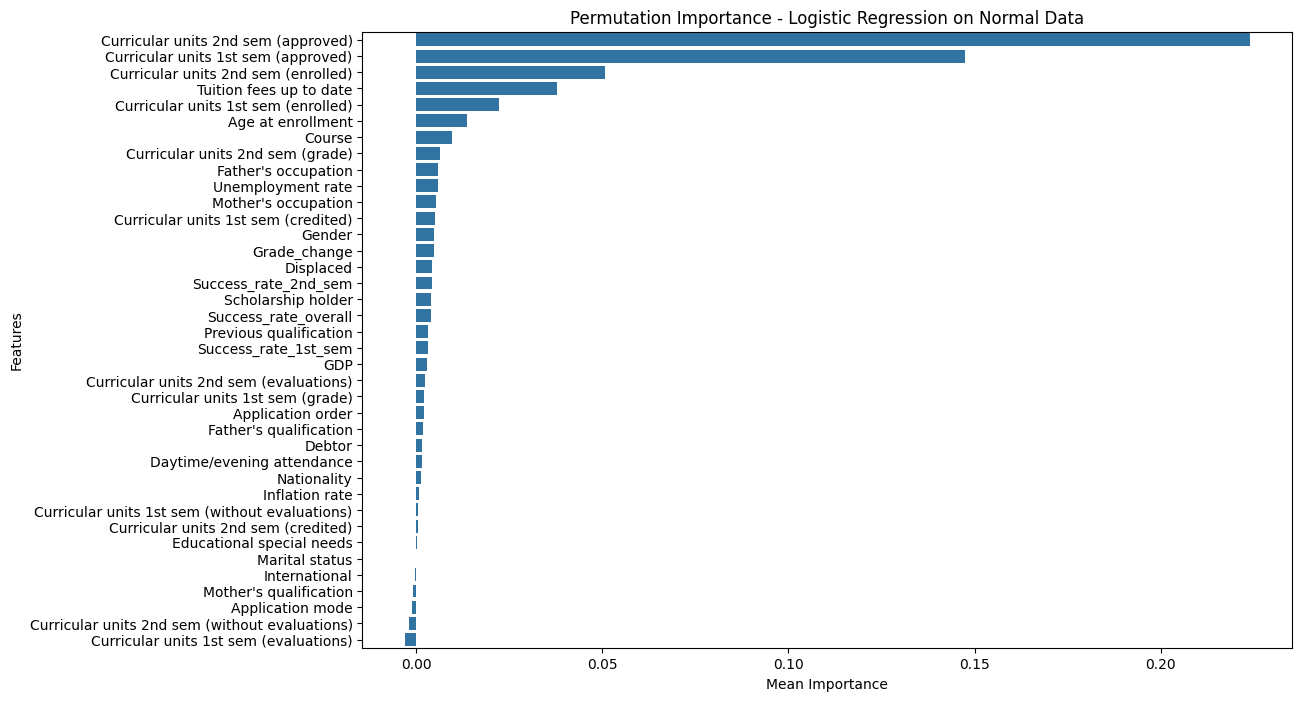

In [10]:
# Calculate permutation feature importance for Logistic Regression on normal data
result = permutation_importance(logreg, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
perm_importances_logreg = pd.Series(result.importances_mean, index=X_test.columns).sort_values(ascending=False)

# Visualize permutation importance
plt.figure(figsize=(12, 8))
sns.barplot(x=perm_importances_logreg.values, y=perm_importances_logreg.index)
plt.title('Permutation Importance - Logistic Regression on Normal Data')
plt.xlabel('Mean Importance')
plt.ylabel('Features')
# Save permutation importance plot
plt.savefig('images/permutation_importance_logistic_regression_normal.png', dpi=500)

plt.show()

Logistic Regression Performance on Balanced Test Set
Macro F1 Score: 0.7614708504409181
Macro Precision: 0.764343365947202
Macro Recall: 0.7616892911010558
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.73      0.78       442
           1       0.76      0.84      0.80       442
           2       0.70      0.71      0.71       442

    accuracy                           0.76      1326
   macro avg       0.76      0.76      0.76      1326
weighted avg       0.76      0.76      0.76      1326



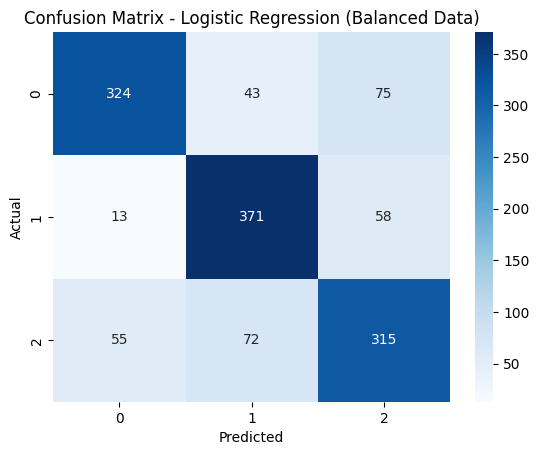

In [11]:
# Do the same for balanced data

# Initialize model
logreg_bal = LogisticRegression(max_iter=5000, random_state=42)

# Fit model
logreg_bal.fit(X_train_bal, y_train_bal)

# Predict
y_pred_bal = logreg_bal.predict(X_test_bal)

# Evaluate
print("Logistic Regression Performance on Balanced Test Set")
print("Macro F1 Score:", f1_score(y_test_bal, y_pred_bal, average='macro'))
print("Macro Precision:", precision_score(y_test_bal, y_pred_bal, average='macro'))
print("Macro Recall:", recall_score(y_test_bal, y_pred_bal, average='macro'))
print("Classification Report:")
print(classification_report(y_test_bal, y_pred_bal))
# Plot confusion matrix
conf_mat_bal = confusion_matrix(y_test_bal, y_pred_bal)
sns.heatmap(conf_mat_bal, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression (Balanced Data)')
# Save confusion matrix
plt.savefig('images/confusion_matrix_logistic_regression_balanced.png', dpi=500)

plt.show()

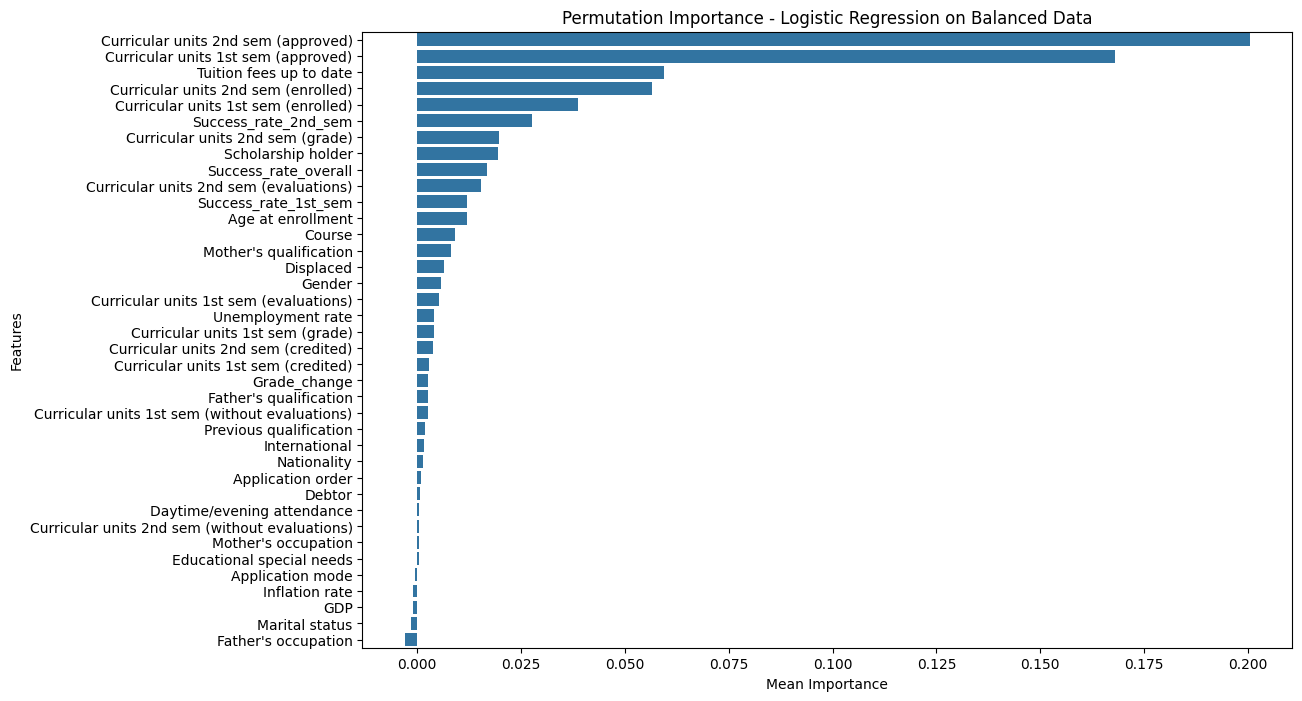

In [12]:
# Calculate permutation feature importance for Logistic Regression on balanced data
result_bal = permutation_importance(logreg_bal, X_test_bal, y_test_bal, n_repeats=10, random_state=42, n_jobs=-1)
perm_importances_logreg_bal = pd.Series(result_bal.importances_mean, index=X_test_bal.columns).sort_values(ascending=False)

# Visualize permutation importance for balanced data
plt.figure(figsize=(12, 8))
sns.barplot(x=perm_importances_logreg_bal.values, y=perm_importances_logreg_bal.index)
plt.title('Permutation Importance - Logistic Regression on Balanced Data')
plt.xlabel('Mean Importance')
plt.ylabel('Features')
# Save permutation importance plot
plt.savefig('images/permutation_importance_logistic_regression_balanced.png', dpi=500)

plt.show()

Logistic Regression Performance on No Enrolled Test Set
Macro F1 Score: 0.9081785023622433
Macro Precision: 0.921579831932773
Macro Recall: 0.8996558536740806
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.83      0.88       284
           1       0.90      0.97      0.93       442

    accuracy                           0.91       726
   macro avg       0.92      0.90      0.91       726
weighted avg       0.92      0.91      0.91       726



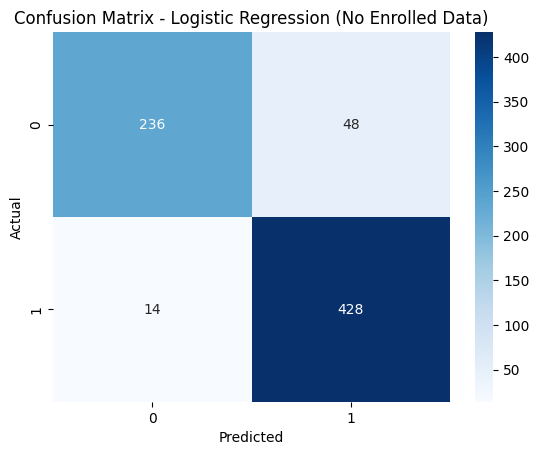

In [13]:
# Do the same for no enrolled data
# Initialize model
logreg_no_enrolled = LogisticRegression(max_iter=5000, random_state=42)

# Fit model
logreg_no_enrolled.fit(X_train_no_enrolled, y_train_no_enrolled)

# Predict
y_pred_no_enrolled = logreg_no_enrolled.predict(X_test_no_enrolled)

# Evaluate
print("Logistic Regression Performance on No Enrolled Test Set")
print("Macro F1 Score:", f1_score(y_test_no_enrolled, y_pred_no_enrolled, average='macro'))
print("Macro Precision:", precision_score(y_test_no_enrolled, y_pred_no_enrolled, average='macro'))
print("Macro Recall:", recall_score(y_test_no_enrolled, y_pred_no_enrolled, average='macro'))
print("Classification Report:")
print(classification_report(y_test_no_enrolled, y_pred_no_enrolled))
# Plot confusion matrix
conf_mat_no_enrolled = confusion_matrix(y_test_no_enrolled, y_pred_no_enrolled)
sns.heatmap(conf_mat_no_enrolled, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression (No Enrolled Data)')
# Save confusion matrix
plt.savefig('images/confusion_matrix_logistic_regression_no_enrolled.png', dpi=500)

plt.show()

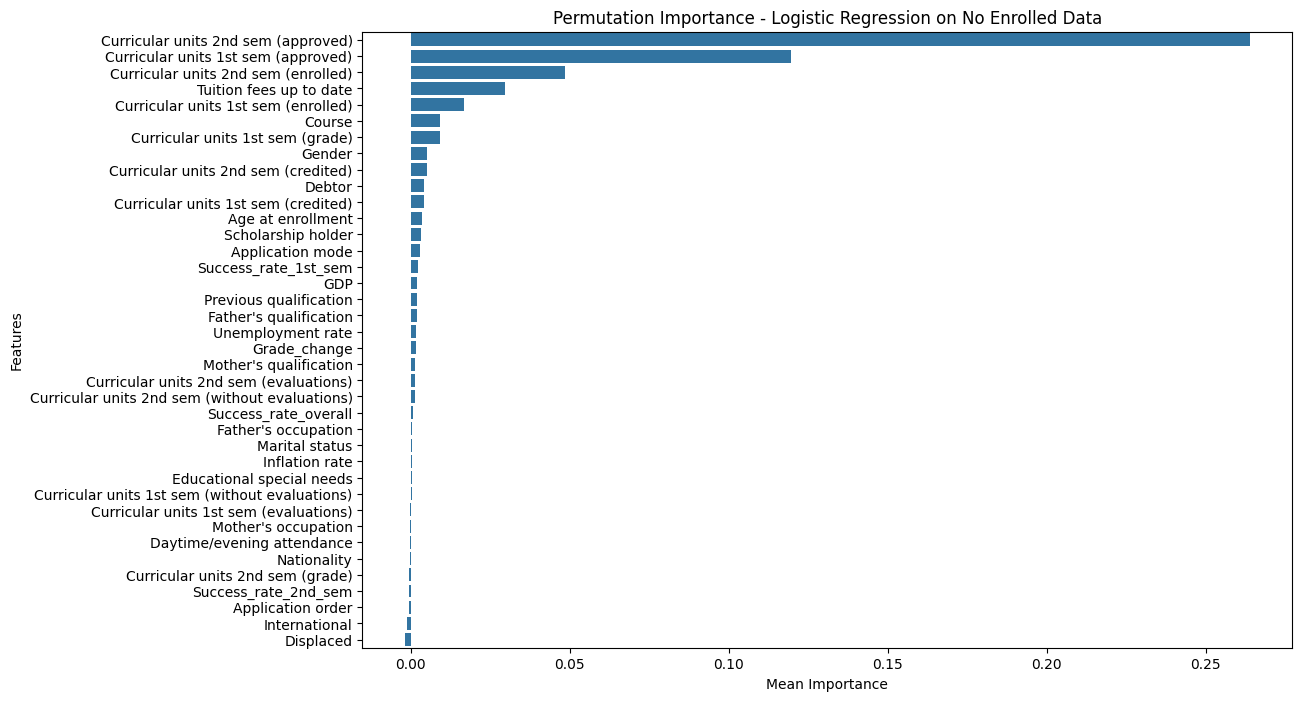

In [14]:
# Calculate permutation feature importance for Logistic Regression on no enrolled data
result_no_enrolled = permutation_importance(logreg_no_enrolled, X_test_no_enrolled, y_test_no_enrolled, n_repeats=10, random_state=42, n_jobs=-1)
perm_importances_logreg_no_enrolled = pd.Series(result_no_enrolled.importances_mean, index=X_test_no_enrolled.columns).sort_values(ascending=False)

# Visualize permutation importance for no enrolled data
plt.figure(figsize=(12, 8))
sns.barplot(x=perm_importances_logreg_no_enrolled.values, y=perm_importances_logreg_no_enrolled.index)
plt.title('Permutation Importance - Logistic Regression on No Enrolled Data')
plt.xlabel('Mean Importance')
plt.ylabel('Features')
# Save permutation importance plot
plt.savefig('images/permutation_importance_logistic_regression_no_enrolled.png', dpi=500)

plt.show()

# SUPPORT VECTOR CLASSIFIER

SVC Performance on Test Set
Macro F1 Score: 0.6428034526002216
Macro Precision: 0.6781185680456593
Macro Recall: 0.6322447190614016
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.65      0.73       284
           1       0.75      0.94      0.83       442
           2       0.45      0.30      0.36       159

    accuracy                           0.73       885
   macro avg       0.68      0.63      0.64       885
weighted avg       0.72      0.73      0.72       885



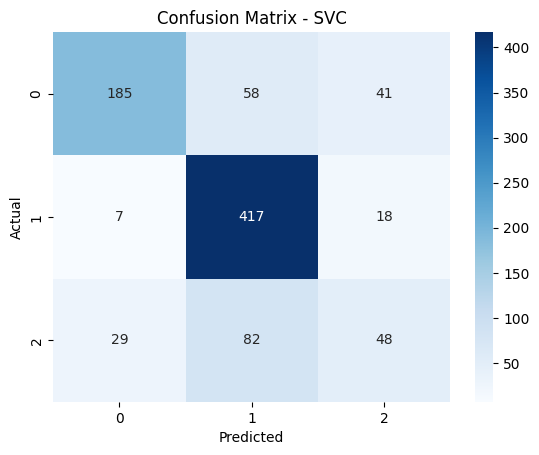

In [15]:
# Initialize model
svc = SVC(random_state=42)

# Fit model
svc.fit(X_train, y_train)
    
# Predict
y_pred = svc.predict(X_test)

# Evaluate
print("SVC Performance on Test Set")
print("Macro F1 Score:", f1_score(y_test, y_pred, average='macro'))
print("Macro Precision:", precision_score(y_test, y_pred, average='macro'))
print("Macro Recall:", recall_score(y_test, y_pred, average='macro'))
print("Classification Report:")
print(classification_report(y_test, y_pred))
# Plot confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - SVC')
# Save confusion matrix
plt.savefig('images/confusion_matrix_svc.png', dpi=500)

plt.show()

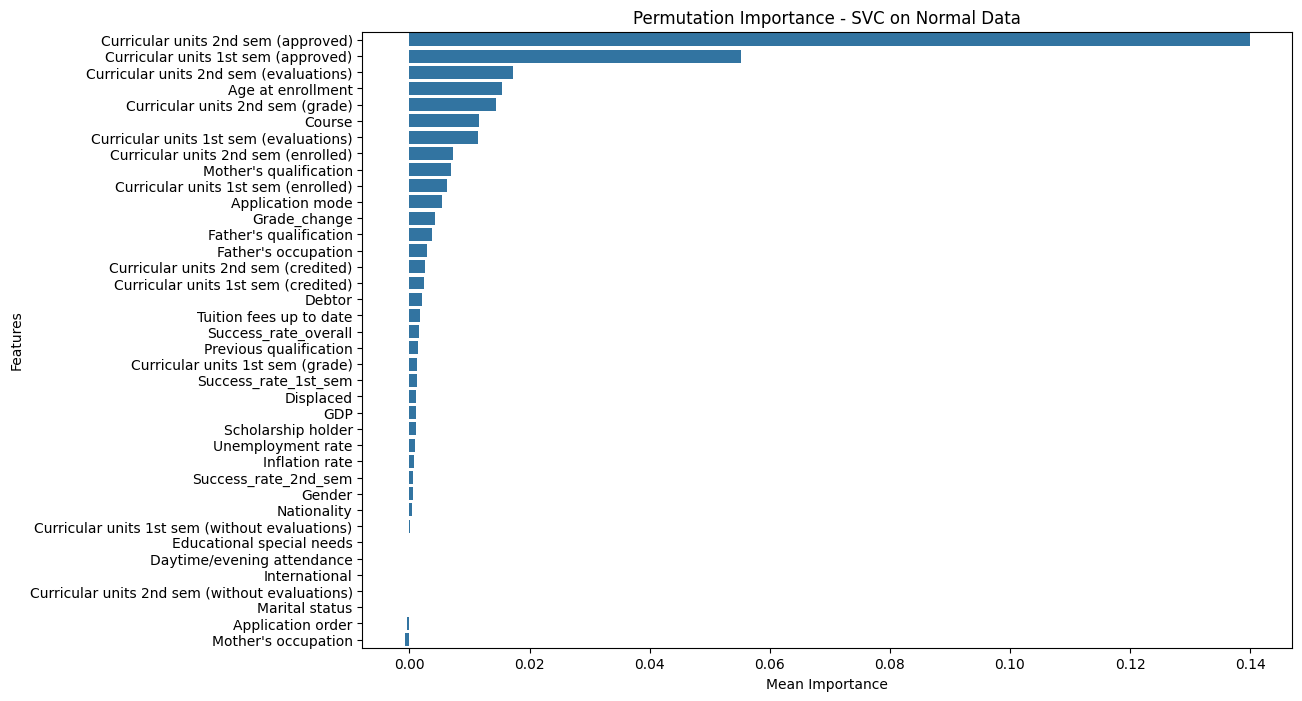

In [16]:
# Calculate permutation feature importance for SVC on normal data
result = permutation_importance(svc, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
perm_importances_svc = pd.Series(result.importances_mean, index=X_test.columns).sort_values(ascending=False)

# Visualize permutation importance
plt.figure(figsize=(12, 8))
sns.barplot(x=perm_importances_svc.values, y=perm_importances_svc.index)
plt.title('Permutation Importance - SVC on Normal Data')
plt.xlabel('Mean Importance')
plt.ylabel('Features')
# Save permutation importance plot
plt.savefig('images/permutation_importance_svc_normal.png', dpi=500)

plt.show()

SVC Performance on Balanced Test Set
Macro F1 Score: 0.7145792459287739
Macro Precision: 0.7212663948243677
Macro Recall: 0.7149321266968326
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.64      0.71       442
           1       0.74      0.81      0.77       442
           2       0.63      0.69      0.66       442

    accuracy                           0.71      1326
   macro avg       0.72      0.71      0.71      1326
weighted avg       0.72      0.71      0.71      1326



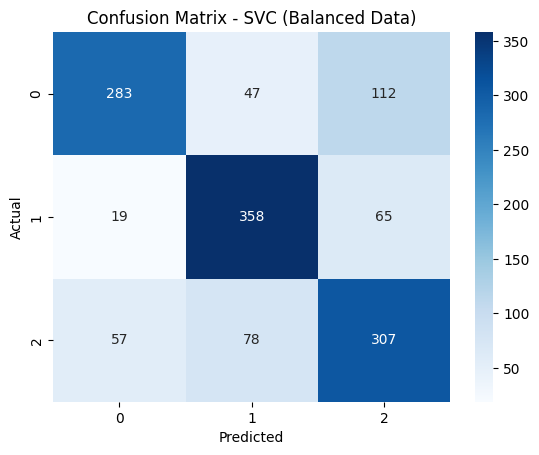

In [17]:
# Do the same for balanced data

# Initialize model
svc_bal = SVC(random_state=42)

# Fit model
svc_bal.fit(X_train_bal, y_train_bal)

# Predict
y_pred_bal = svc_bal.predict(X_test_bal)

# Evaluate
print("SVC Performance on Balanced Test Set")
print("Macro F1 Score:", f1_score(y_test_bal, y_pred_bal, average='macro'))
print("Macro Precision:", precision_score(y_test_bal, y_pred_bal, average='macro'))
print("Macro Recall:", recall_score(y_test_bal, y_pred_bal, average='macro'))
print("Classification Report:")
print(classification_report(y_test_bal, y_pred_bal))
# Plot confusion matrix
conf_mat_bal = confusion_matrix(y_test_bal, y_pred_bal)
sns.heatmap(conf_mat_bal, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - SVC (Balanced Data)')
# Save confusion matrix
plt.savefig('images/confusion_matrix_svc_balanced.png', dpi=500)

plt.show()

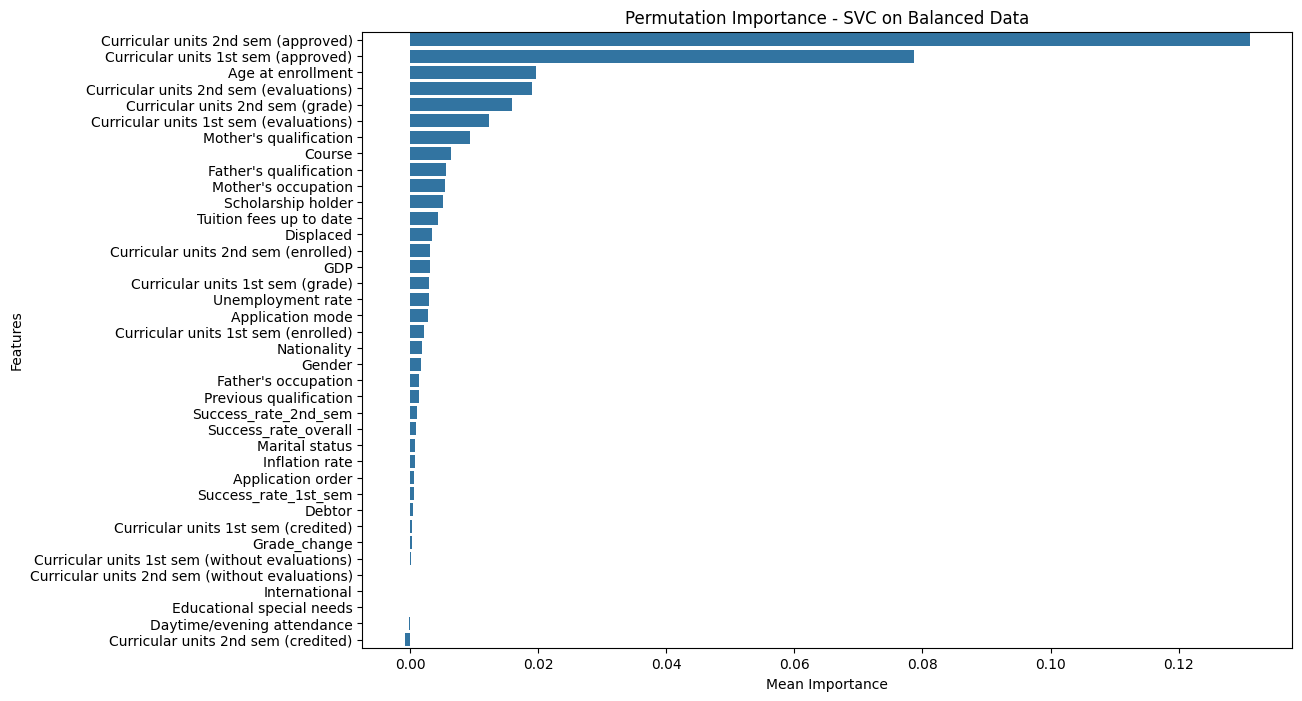

In [18]:
# Calculate permutation feature importance for SVC on balanced data
result_bal = permutation_importance(svc_bal, X_test_bal, y_test_bal, n_repeats=10, random_state=42, n_jobs=-1)
perm_importances_svc_bal = pd.Series(result_bal.importances_mean, index=X_test_bal.columns).sort_values(ascending=False)

# Visualize permutation importance for balanced data
plt.figure(figsize=(12, 8))
sns.barplot(x=perm_importances_svc_bal.values, y=perm_importances_svc_bal.index)
plt.title('Permutation Importance - SVC on Balanced Data')
plt.xlabel('Mean Importance')
plt.ylabel('Features')
# Save permutation importance plot
plt.savefig('images/permutation_importance_svc_balanced.png', dpi=500)

plt.show()

SVC Performance on No Enrolled Test Set
Macro F1 Score: 0.8827519379844961
Macro Precision: 0.9061932849364791
Macro Recall: 0.8708574979287489
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.77      0.85       284
           1       0.87      0.97      0.92       442

    accuracy                           0.89       726
   macro avg       0.91      0.87      0.88       726
weighted avg       0.90      0.89      0.89       726



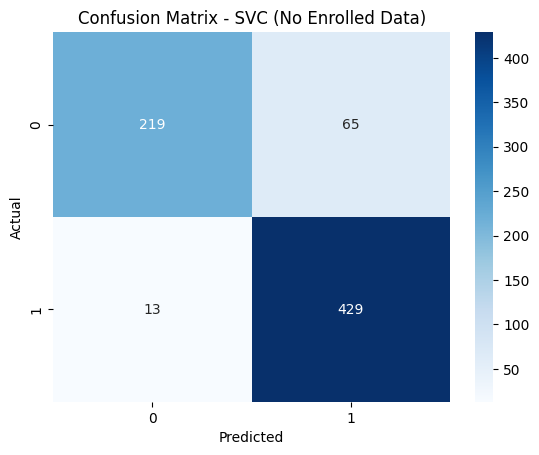

In [19]:
# Do the same for no enrolled data

# Initialize model
svc_no_enrolled = SVC(random_state=42)

# Fit model
svc_no_enrolled.fit(X_train_no_enrolled, y_train_no_enrolled)

# Predict
y_pred_no_enrolled = svc_no_enrolled.predict(X_test_no_enrolled)

# Evaluate
print("SVC Performance on No Enrolled Test Set")
print("Macro F1 Score:", f1_score(y_test_no_enrolled, y_pred_no_enrolled, average='macro'))
print("Macro Precision:", precision_score(y_test_no_enrolled, y_pred_no_enrolled, average='macro'))
print("Macro Recall:", recall_score(y_test_no_enrolled, y_pred_no_enrolled, average='macro'))
print("Classification Report:")
print(classification_report(y_test_no_enrolled, y_pred_no_enrolled))
# Plot confusion matrix
conf_mat_no_enrolled = confusion_matrix(y_test_no_enrolled, y_pred_no_enrolled)
sns.heatmap(conf_mat_no_enrolled, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - SVC (No Enrolled Data)')
# Save confusion matrix
plt.savefig('images/confusion_matrix_svc_no_enrolled.png', dpi=500)

plt.show()

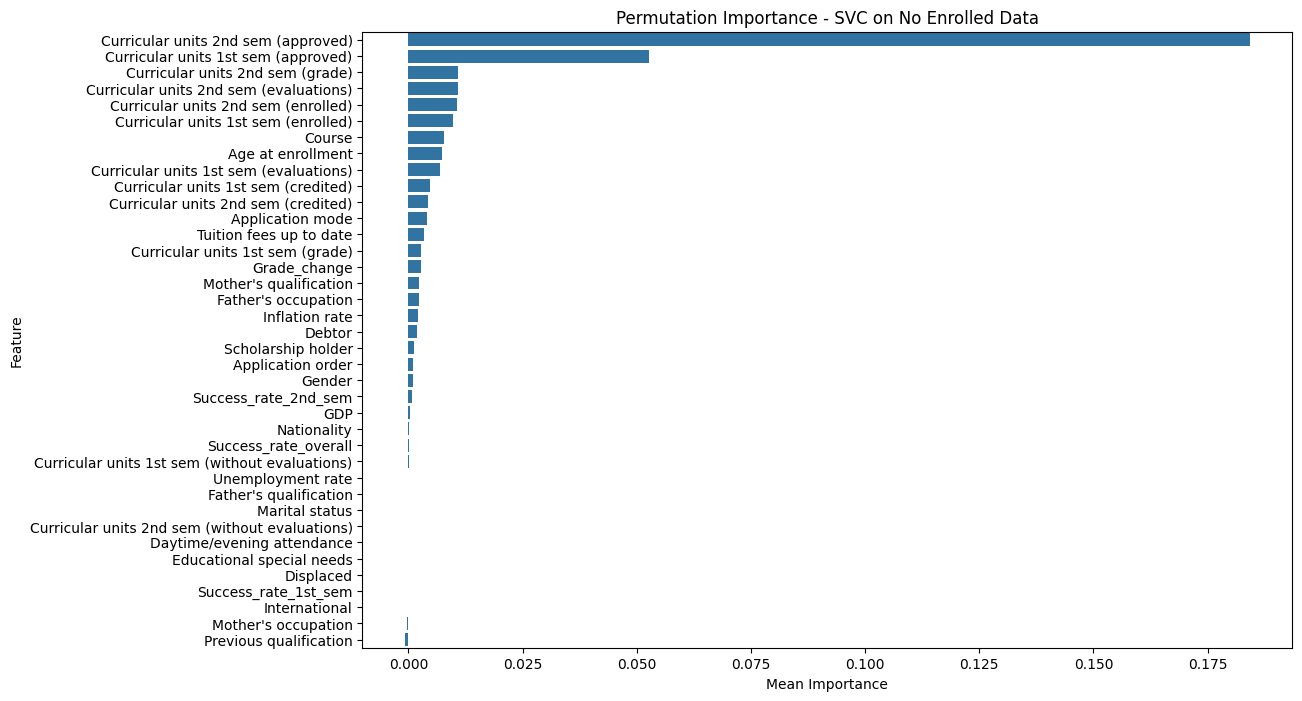

In [20]:
# Calculate permutation feature importance for SVC on no enrolled data
result_no_enrolled = permutation_importance(svc_no_enrolled, X_test_no_enrolled, y_test_no_enrolled, n_repeats=10, random_state=42, n_jobs=-1)
perm_importances_svc_no_enrolled = pd.Series(result_no_enrolled.importances_mean, index=X_test_no_enrolled.columns).sort_values(ascending=False)

# Visualize permutation importance for no enrolled data
plt.figure(figsize=(12, 8))
sns.barplot(x=perm_importances_svc_no_enrolled.values, y=perm_importances_svc_no_enrolled.index)
plt.title('Permutation Importance - SVC on No Enrolled Data')
plt.xlabel('Mean Importance')
plt.ylabel('Feature')
# Save permutation importance plot
plt.savefig('images/perm_importance_svc_no_enrolled.png', dpi=500)

plt.show()

# Random Forest Classifier

Random Forest Classifier Performance on Test Set
Macro F1 Score: 0.6825600794286234
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.75      0.79       284
           1       0.79      0.92      0.85       442
           2       0.50      0.35      0.41       159

    accuracy                           0.76       885
   macro avg       0.70      0.67      0.68       885
weighted avg       0.75      0.76      0.75       885



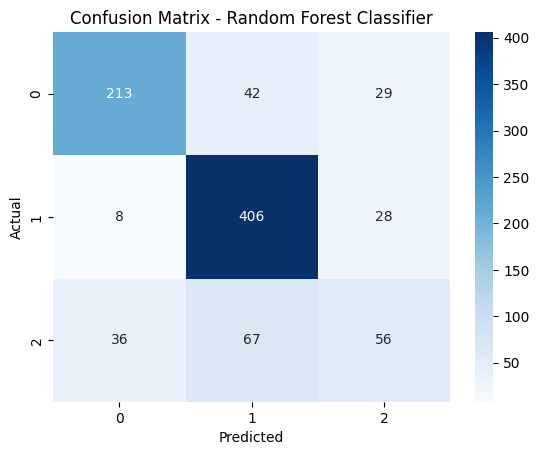

In [21]:
# Initialize model
rfc = RandomForestClassifier(random_state=42)

# Fit model
rfc.fit(X_train, y_train)

# Predict
y_pred = rfc.predict(X_test)

# Evaluate
print("Random Forest Classifier Performance on Test Set")
print("Macro F1 Score:", f1_score(y_test, y_pred, average='macro'))
print("Classification Report:")
print(classification_report(y_test, y_pred))
# Plot confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest Classifier')
# Save confusion matrix
plt.savefig('images/confusion_matrix_random_forest.png', dpi=500)

plt.show()

,Feature,Importance
36,Success_rate_overall,0.123968
35,Success_rate_2nd_sem,0.099357
28,Curricular units 2nd sem (approved),0.075308
29,Curricular units 2nd sem (grade),0.067324
34,Success_rate_1st_sem,0.055661
23,Curricular units 1st sem (grade),0.042742
22,Curricular units 1st sem (approved),0.042639
37,Grade_change,0.038141
3,Course,0.035103
17,Age at enrollment,0.034155


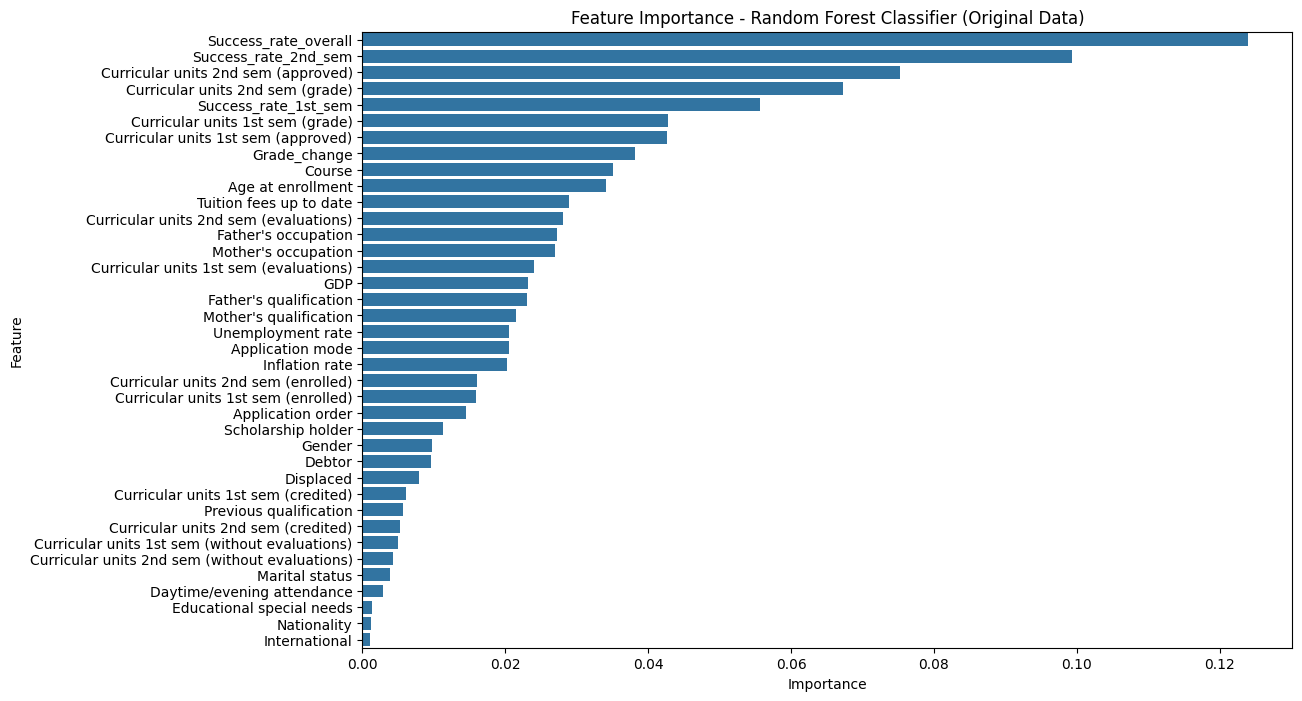

In [22]:
# Check feature importance for Random Forest on original data
importances_rfc = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rfc.feature_importances_
})
importances_rfc = importances_rfc.sort_values(by='Importance', ascending=False)
display(importances_rfc)

# Visualize feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importances_rfc)
plt.title('Feature Importance - Random Forest Classifier (Original Data)')
# Save feature importance plot
plt.savefig('images/feature_importance_random_forest.png', dpi=500)

plt.show()

Random Forest Classifier Performance on Balanced Test Set
Macro F1 Score: 0.8273035851725027
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.78      0.83       442
           1       0.82      0.88      0.85       442
           2       0.79      0.82      0.80       442

    accuracy                           0.83      1326
   macro avg       0.83      0.83      0.83      1326
weighted avg       0.83      0.83      0.83      1326



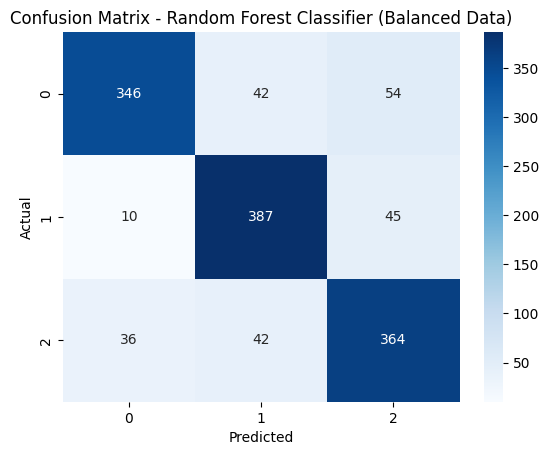

In [23]:
# Do the same for balanced data

# Initialize model
rfc_bal = RandomForestClassifier(random_state=42)

# Fit model
rfc_bal.fit(X_train_bal, y_train_bal)

# Predict
y_pred_bal = rfc_bal.predict(X_test_bal)

# Evaluate
print("Random Forest Classifier Performance on Balanced Test Set")
print("Macro F1 Score:", f1_score(y_test_bal, y_pred_bal, average='macro'))
print("Classification Report:")
print(classification_report(y_test_bal, y_pred_bal))
# Plot confusion matrix
conf_mat_bal = confusion_matrix(y_test_bal, y_pred_bal)
sns.heatmap(conf_mat_bal, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest Classifier (Balanced Data)')
# Save confusion matrix
plt.savefig('images/confusion_matrix_random_forest_balanced.png', dpi=500)

plt.show()

,Feature,Importance
36,Success_rate_overall,0.119135
35,Success_rate_2nd_sem,0.110810
29,Curricular units 2nd sem (grade),0.065570
28,Curricular units 2nd sem (approved),0.060215
34,Success_rate_1st_sem,0.057077
22,Curricular units 1st sem (approved),0.043557
14,Tuition fees up to date,0.040955
23,Curricular units 1st sem (grade),0.040278
17,Age at enrollment,0.035827
37,Grade_change,0.033659


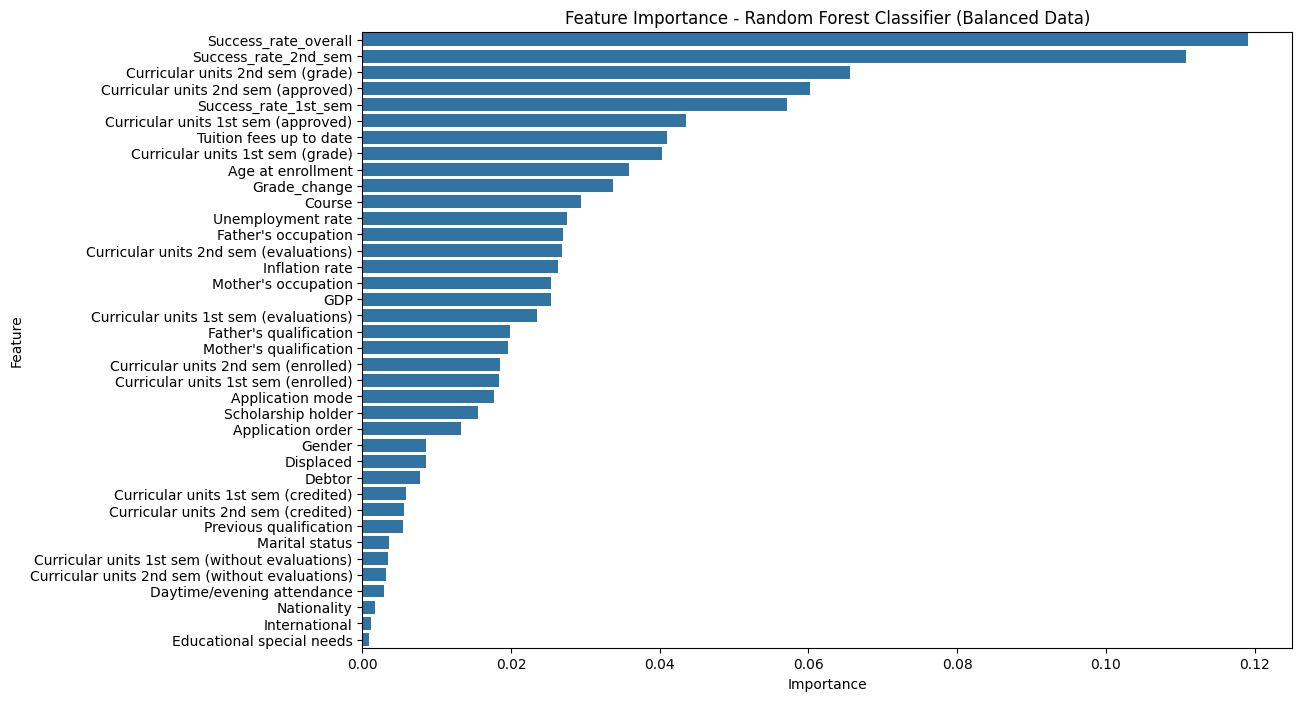

In [24]:
# Check feature importance for Random Forest on balanced data
importances_rfc_bal = pd.DataFrame({
    'Feature': X_train_bal.columns,
    'Importance': rfc_bal.feature_importances_
})
importances_rfc_bal = importances_rfc_bal.sort_values(by='Importance', ascending=False)
display(importances_rfc_bal)

# Visualize feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importances_rfc_bal)
plt.title('Feature Importance - Random Forest Classifier (Balanced Data)')
# Save feature importance plot
plt.savefig('images/feature_importance_random_forest_balanced.png', dpi=500)

plt.show()

Random Forest Classifier Performance on No Enrolled Test Set
Macro F1 Score: 0.9100073764445538
Macro Precision: 0.9208567503434495
Macro Recall: 0.9026751003760117
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.84      0.89       284
           1       0.90      0.96      0.93       442

    accuracy                           0.92       726
   macro avg       0.92      0.90      0.91       726
weighted avg       0.92      0.92      0.92       726



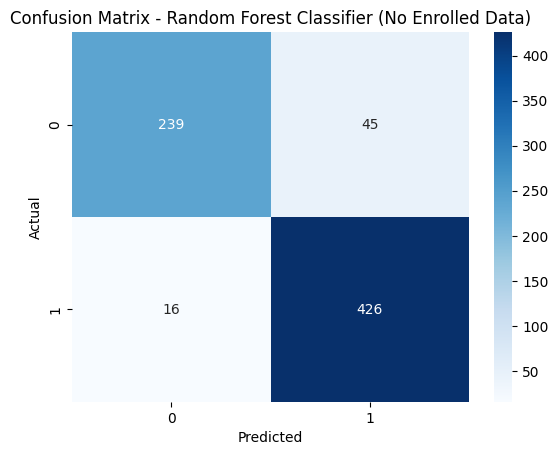

In [25]:
# Do the same for no enrolled data

# Initialize model
rfc_no_enrolled = RandomForestClassifier(random_state=42)

# Fit model
rfc_no_enrolled.fit(X_train_no_enrolled, y_train_no_enrolled)

# Predict
y_pred_no_enrolled = rfc_no_enrolled.predict(X_test_no_enrolled)

# Evaluate
print("Random Forest Classifier Performance on No Enrolled Test Set")
print("Macro F1 Score:", f1_score(y_test_no_enrolled, y_pred_no_enrolled, average='macro'))
print("Macro Precision:", precision_score(y_test_no_enrolled, y_pred_no_enrolled, average='macro'))
print("Macro Recall:", recall_score(y_test_no_enrolled, y_pred_no_enrolled, average='macro'))
print("Classification Report:")
print(classification_report(y_test_no_enrolled, y_pred_no_enrolled))
# Plot confusion matrix
conf_mat_no_enrolled = confusion_matrix(y_test_no_enrolled, y_pred_no_enrolled)
sns.heatmap(conf_mat_no_enrolled, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest Classifier (No Enrolled Data)')
# Save confusion matrix
plt.savefig('images/confusion_matrix_random_forest_no_enrolled.png', dpi=500)

plt.show()

,Feature,Importance
36,Success_rate_overall,0.175825
35,Success_rate_2nd_sem,0.140620
28,Curricular units 2nd sem (approved),0.093489
22,Curricular units 1st sem (approved),0.075949
34,Success_rate_1st_sem,0.075431
29,Curricular units 2nd sem (grade),0.063480
23,Curricular units 1st sem (grade),0.038248
14,Tuition fees up to date,0.036220
37,Grade_change,0.024525
3,Course,0.023567


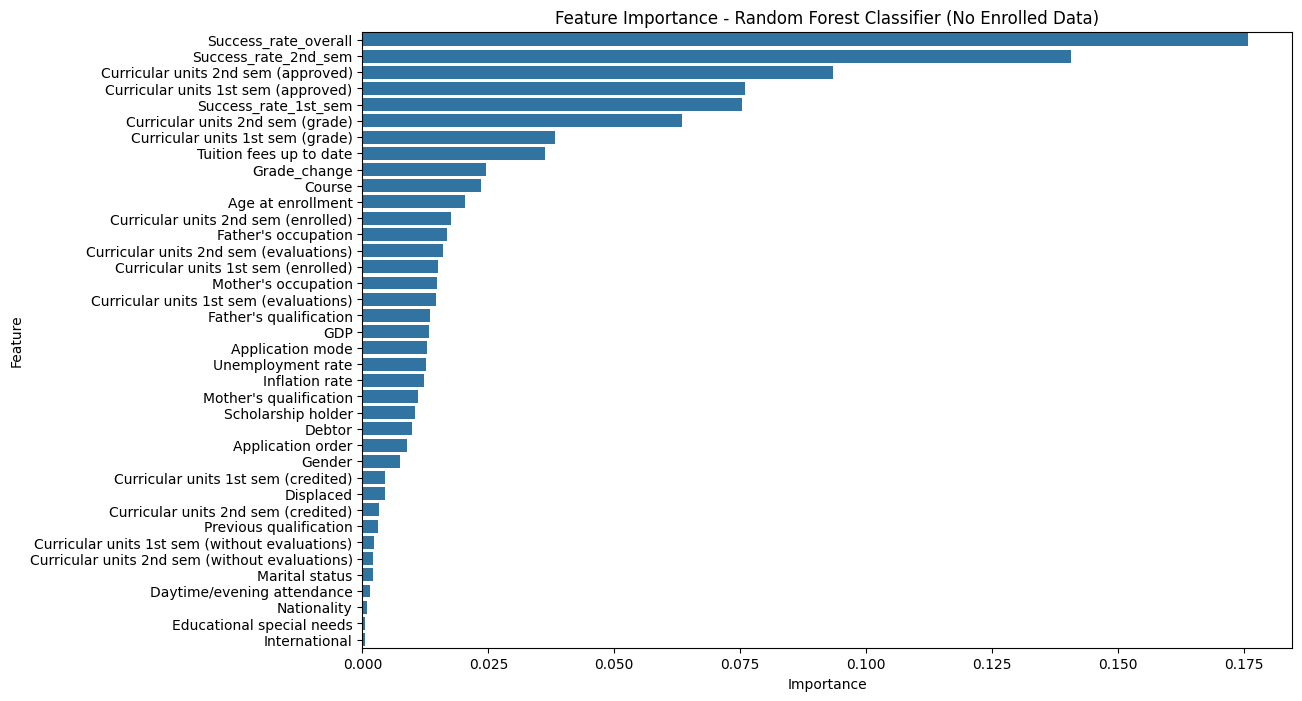

In [26]:
# Check feature importance for Random Forest on no enrolled data
importances_rfc_no_enrolled = pd.DataFrame({
    'Feature': X_train_no_enrolled.columns,
    'Importance': rfc_no_enrolled.feature_importances_
})
importances_rfc_no_enrolled = importances_rfc_no_enrolled.sort_values(by='Importance', ascending=False)
display(importances_rfc_no_enrolled)

# Visualize feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importances_rfc_no_enrolled)
plt.title('Feature Importance - Random Forest Classifier (No Enrolled Data)')
# Save feature importance plot
plt.savefig('images/feature_importance_random_forest_no_enrolled.png', dpi=500)

plt.show()

# XGBoost

XGBoost Classifier Performance on Test Set
Macro F1 Score: 0.692920142034509
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.73      0.77       284
           1       0.80      0.93      0.86       442
           2       0.52      0.40      0.45       159

    accuracy                           0.77       885
   macro avg       0.71      0.68      0.69       885
weighted avg       0.76      0.77      0.76       885



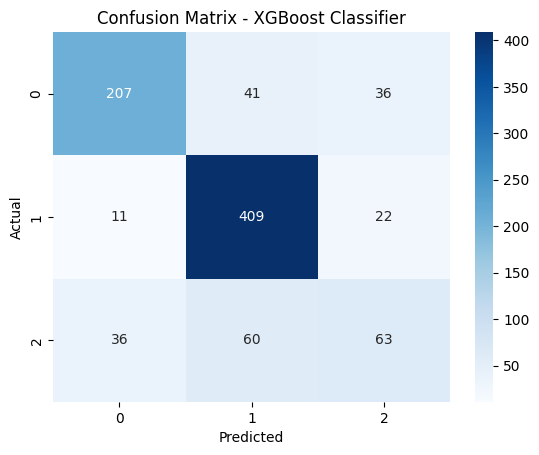

In [27]:
# Initialize model
xgbc = XGBClassifier(random_state=42)

# Fit model
xgbc.fit(X_train, y_train)

# Predict
y_pred = xgbc.predict(X_test)

# Evaluate
print("XGBoost Classifier Performance on Test Set")
print("Macro F1 Score:", f1_score(y_test, y_pred, average='macro'))
print("Classification Report:")
print(classification_report(y_test, y_pred))
# Plot confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - XGBoost Classifier')
# Save confusion matrix
plt.savefig('images/confusion_matrix_xgboost.png', dpi=500)

plt.show()

,Feature,Importance
36,Success_rate_overall,0.246551
14,Tuition fees up to date,0.098112
35,Success_rate_2nd_sem,0.051203
20,Curricular units 1st sem (enrolled),0.048608
28,Curricular units 2nd sem (approved),0.041185
26,Curricular units 2nd sem (enrolled),0.023625
3,Course,0.023595
13,Debtor,0.021206
16,Scholarship holder,0.019666
15,Gender,0.019428


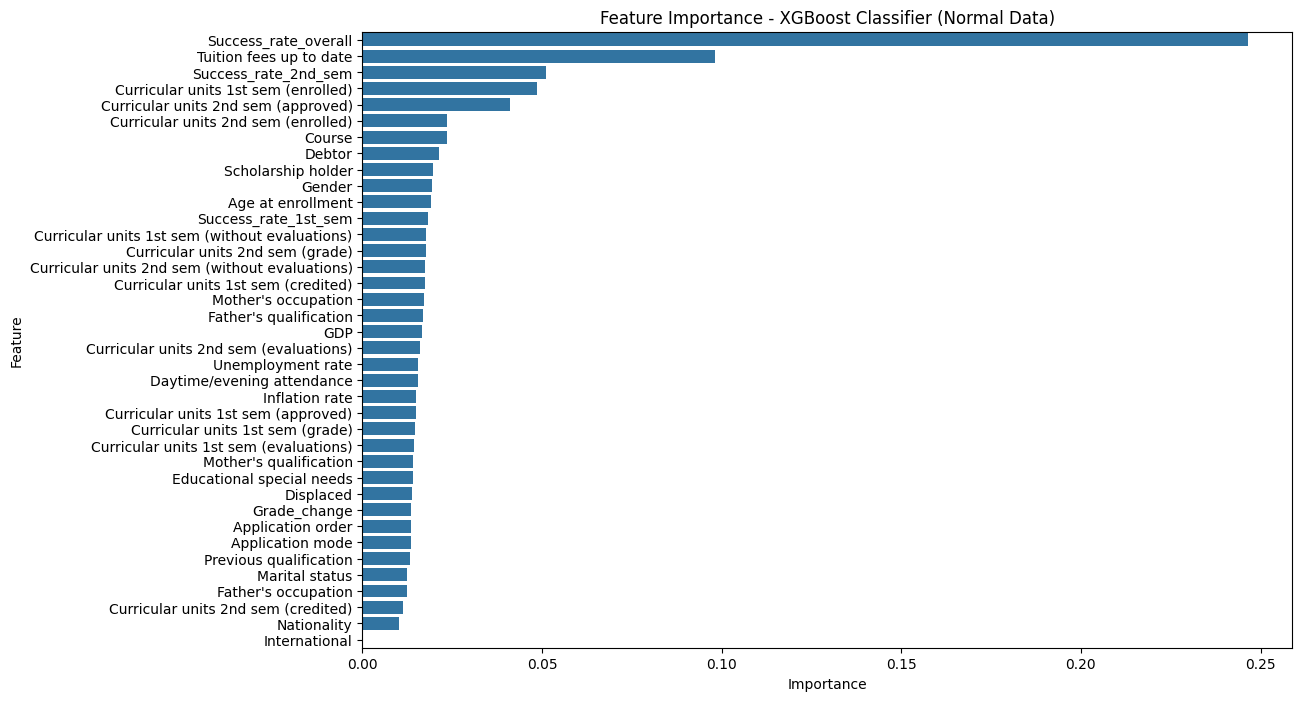

In [28]:
# Check feature importance for XGBoost on normal data
importances_xgb = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgbc.feature_importances_
})
importances_xgb = importances_xgb.sort_values(by='Importance', ascending=False)
display(importances_xgb)

# Visualize feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importances_xgb)
plt.title('Feature Importance - XGBoost Classifier (Normal Data)')
# Save feature importance plot
plt.savefig('images/feature_importance_xgboost_normal.png', dpi=500)

plt.show()

XGBoost Classifier Performance on Balanced Test Set
Macro F1 Score: 0.8323564286095233
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.79      0.83       442
           1       0.81      0.89      0.85       442
           2       0.80      0.82      0.81       442

    accuracy                           0.83      1326
   macro avg       0.84      0.83      0.83      1326
weighted avg       0.84      0.83      0.83      1326



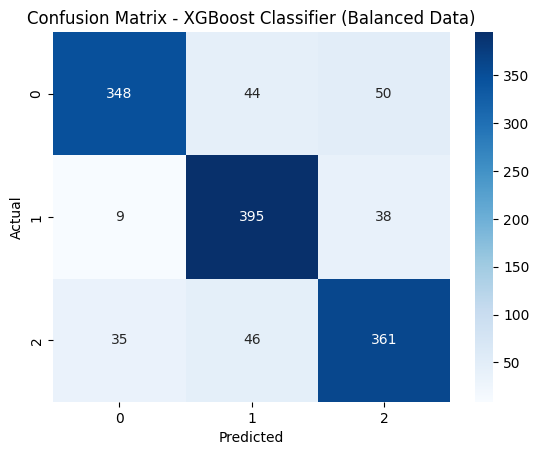

In [29]:
# Do the same for balanced data

# Initialize model
xgbc_bal = XGBClassifier(random_state=42)

# Fit model
xgbc_bal.fit(X_train_bal, y_train_bal)

# Predict
y_pred_bal = xgbc_bal.predict(X_test_bal)

# Evaluate
print("XGBoost Classifier Performance on Balanced Test Set")
print("Macro F1 Score:", f1_score(y_test_bal, y_pred_bal, average='macro'))
print("Classification Report:")
print(classification_report(y_test_bal, y_pred_bal))
# Plot confusion matrix
conf_mat_bal = confusion_matrix(y_test_bal, y_pred_bal)
sns.heatmap(conf_mat_bal, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - XGBoost Classifier (Balanced Data)')
# Save confusion matrix
plt.savefig('images/confusion_matrix_xgboost_balanced.png', dpi=500)

plt.show()

,Feature,Importance
36,Success_rate_overall,0.182193
35,Success_rate_2nd_sem,0.104744
14,Tuition fees up to date,0.096161
26,Curricular units 2nd sem (enrolled),0.051748
20,Curricular units 1st sem (enrolled),0.044443
16,Scholarship holder,0.035348
22,Curricular units 1st sem (approved),0.032368
30,Curricular units 2nd sem (without evaluations),0.018310
17,Age at enrollment,0.018208
34,Success_rate_1st_sem,0.018156


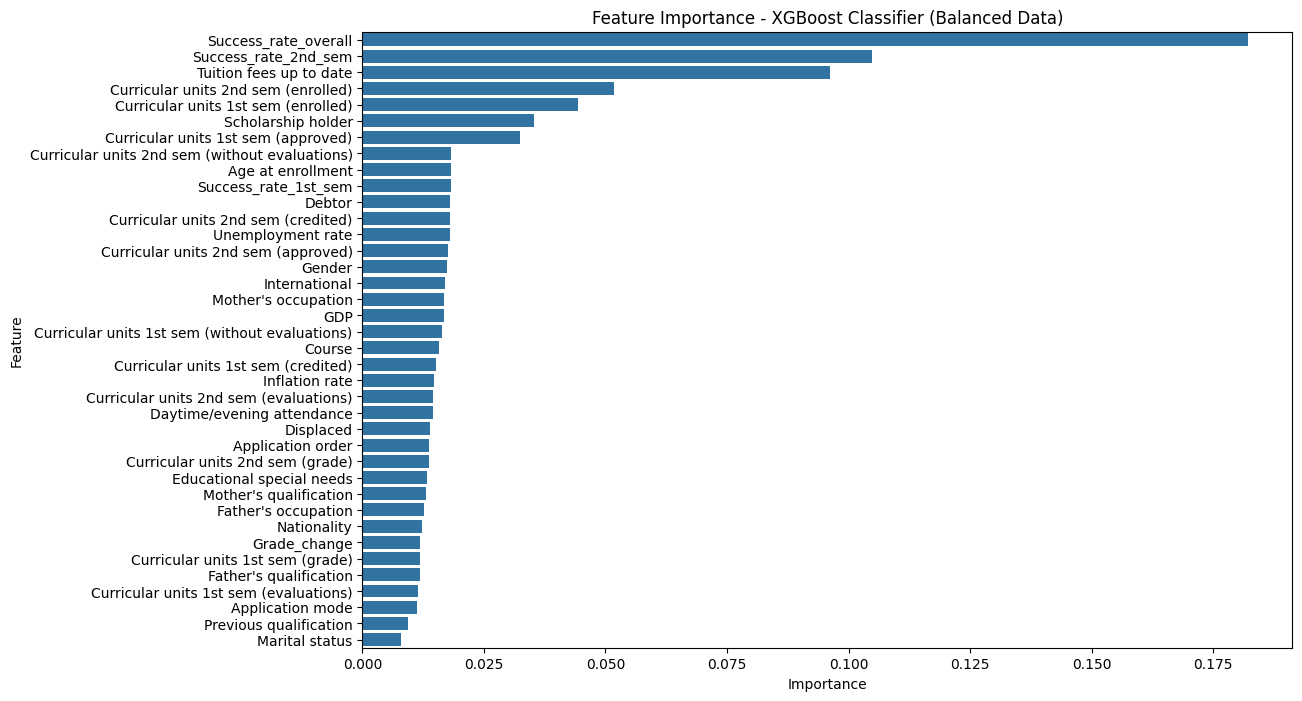

In [30]:
# Check feature importance for XGBoost on balanced data
importances_xgb_bal = pd.DataFrame({
    'Feature': X_train_bal.columns,
    'Importance': xgbc_bal.feature_importances_
})
importances_xgb_bal = importances_xgb_bal.sort_values(by='Importance', ascending=False)
display(importances_xgb_bal)

# Visualize feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importances_xgb_bal)
plt.title('Feature Importance - XGBoost Classifier (Balanced Data)')
# Save feature importance plot
plt.savefig('images/feature_importance_xgboost_balanced.png', dpi=500)

plt.show()

XGBoost Classifier Performance on No Enrolled Test Set
Macro F1 Score: 0.9015971597058556
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.84      0.88       284
           1       0.90      0.95      0.93       442

    accuracy                           0.91       726
   macro avg       0.91      0.90      0.90       726
weighted avg       0.91      0.91      0.91       726



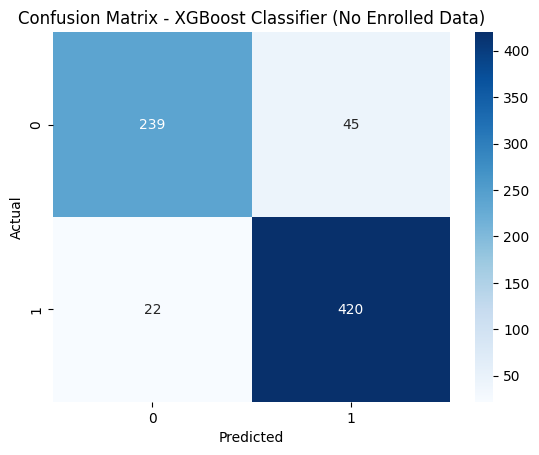

In [31]:
# Do the same for no enrolled data

# Initialize model
xgbc_no_enrolled = XGBClassifier(random_state=42)

# Fit model
xgbc_no_enrolled.fit(X_train_no_enrolled, y_train_no_enrolled)

# Predict
y_pred_no_enrolled = xgbc_no_enrolled.predict(X_test_no_enrolled)

# Evaluate
print("XGBoost Classifier Performance on No Enrolled Test Set")
print("Macro F1 Score:", f1_score(y_test_no_enrolled, y_pred_no_enrolled, average='macro'))
print("Classification Report:")
print(classification_report(y_test_no_enrolled, y_pred_no_enrolled))
# Plot confusion matrix
conf_mat_no_enrolled = confusion_matrix(y_test_no_enrolled, y_pred_no_enrolled)
sns.heatmap(conf_mat_no_enrolled, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - XGBoost Classifier (No Enrolled Data)')
# Save confusion matrix
plt.savefig('images/confusion_matrix_xgboost_no_enrolled.png', dpi=500)

plt.show()

,Feature,Importance
36,Success_rate_overall,0.418107
20,Curricular units 1st sem (enrolled),0.096021
14,Tuition fees up to date,0.062940
35,Success_rate_2nd_sem,0.050498
3,Course,0.019217
28,Curricular units 2nd sem (approved),0.019027
13,Debtor,0.017350
19,Curricular units 1st sem (credited),0.017098
16,Scholarship holder,0.016900
22,Curricular units 1st sem (approved),0.016177


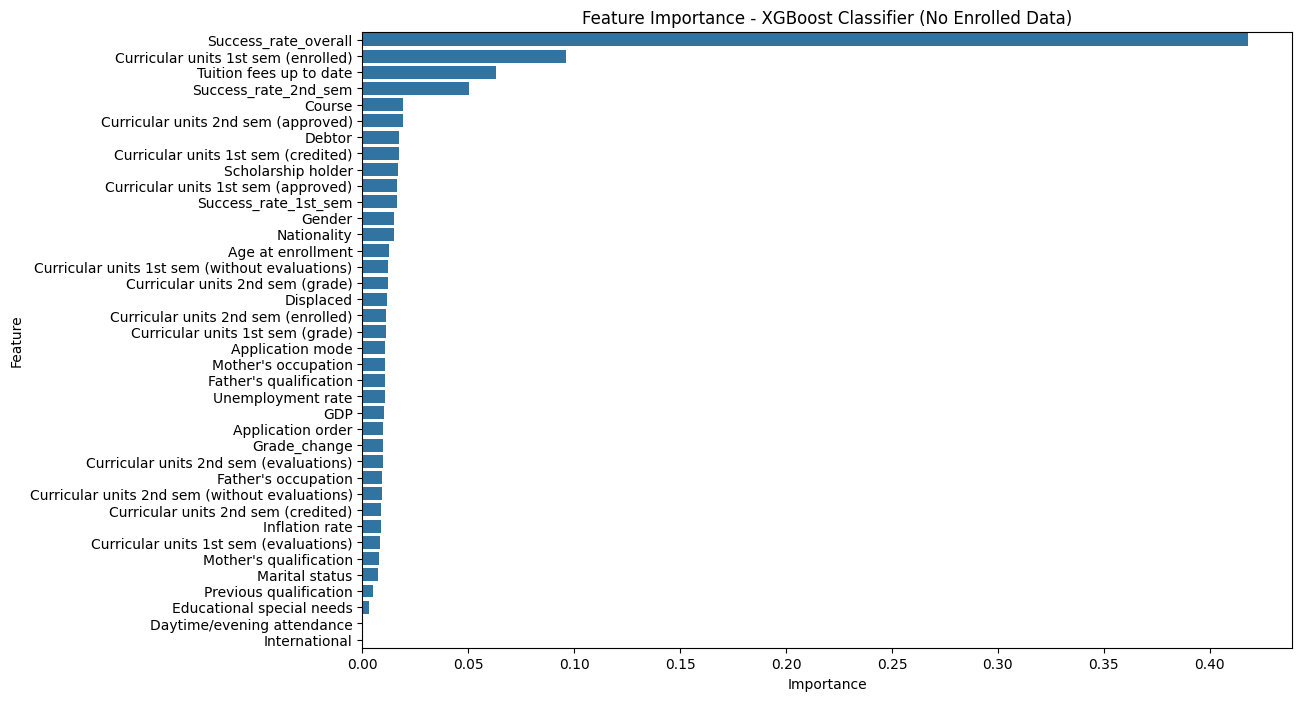

In [32]:
# Check feature importance for XGBoost on no enrolled data
importances_xgb_no_enrolled = pd.DataFrame({
    'Feature': X_train_no_enrolled.columns,
    'Importance': xgbc_no_enrolled.feature_importances_
})
importances_xgb_no_enrolled = importances_xgb_no_enrolled.sort_values(by='Importance', ascending=False)
display(importances_xgb_no_enrolled)

# Visualize feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importances_xgb_no_enrolled)
plt.title('Feature Importance - XGBoost Classifier (No Enrolled Data)')
# Save feature importance plot
plt.savefig('images/feature_importance_xgboost_no_enrolled.png', dpi=500)

plt.show()

# VOTING CLASSIFIER

Voting Classifier Performance on Test Set
Macro F1 Score: 0.6984330416910782
Macro Precision: 0.725122768060887
Macro Recall: 0.6878347787666073
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.75      0.79       284
           1       0.80      0.94      0.86       442
           2       0.55      0.37      0.44       159

    accuracy                           0.78       885
   macro avg       0.73      0.69      0.70       885
weighted avg       0.76      0.78      0.76       885



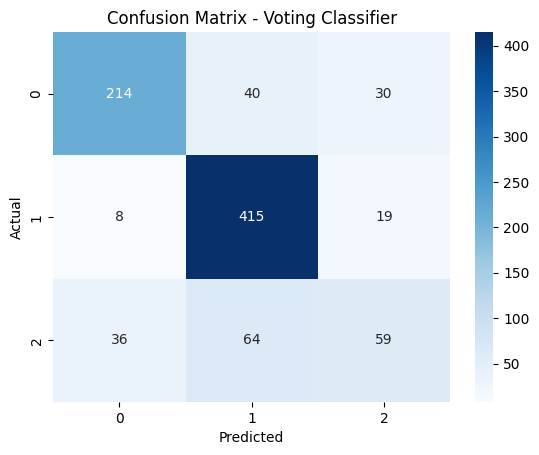

In [33]:
# Initialize model
vc = VotingClassifier(estimators=[
    ('logreg', LogisticRegression(max_iter=5000, random_state=42)),
    ('svc', SVC(probability=True, random_state=42)),
    ('rfc', RandomForestClassifier(random_state=42)),
    ('xgbc', XGBClassifier(random_state=42))
], voting='soft')

# Fit model
vc.fit(X_train, y_train)

# Predict
y_pred = vc.predict(X_test)

# Evaluate
print("Voting Classifier Performance on Test Set")
print("Macro F1 Score:", f1_score(y_test, y_pred, average='macro'))
print("Macro Precision:", precision_score(y_test, y_pred, average='macro'))
print("Macro Recall:", recall_score(y_test, y_pred, average='macro'))
print("Classification Report:")
print(classification_report(y_test, y_pred))
# Plot confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Voting Classifier')
# Save confusion matrix
plt.savefig('images/confusion_matrix_voting_classifier.png', dpi=500)

plt.show()

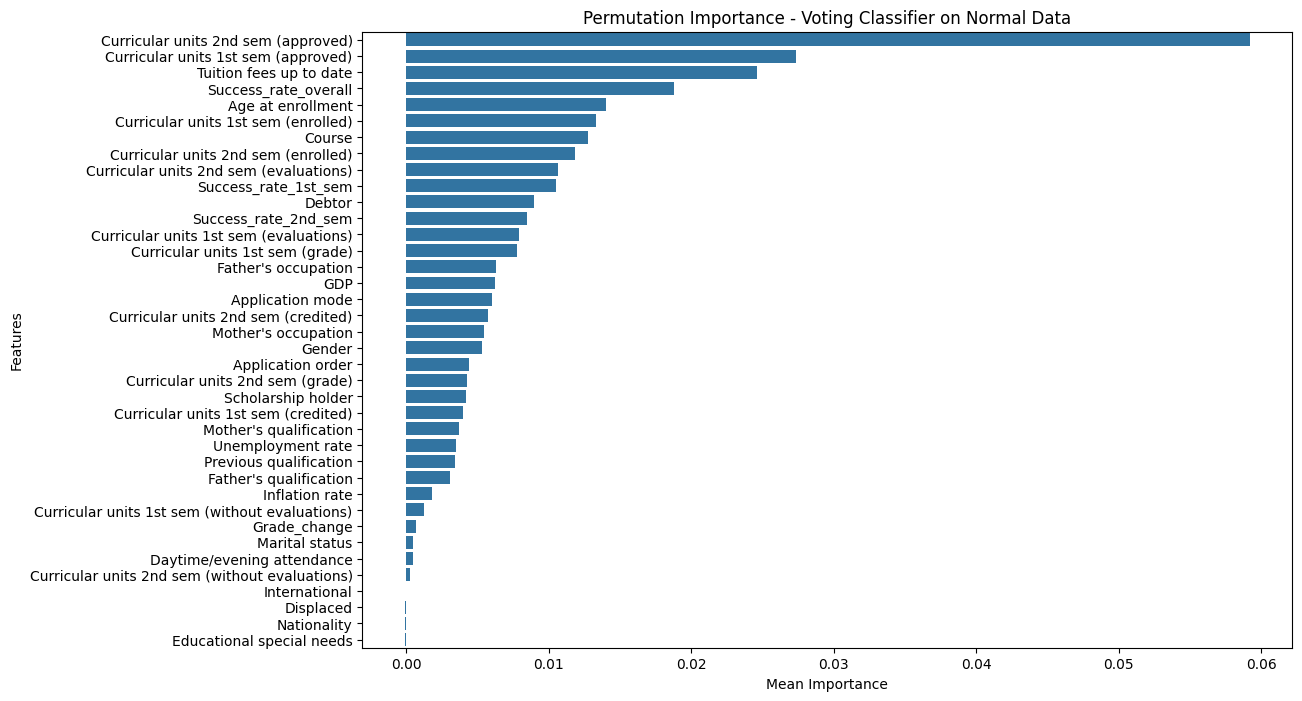

In [34]:
# Calculate permutation feature importance for Voting Classifier on normal data
result = permutation_importance(vc, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
perm_importances_vc = pd.Series(result.importances_mean, index=X_test.columns).sort_values(ascending=False)

# Visualize permutation importance
plt.figure(figsize=(12, 8))
sns.barplot(x=perm_importances_vc.values, y=perm_importances_vc.index)
plt.title('Permutation Importance - Voting Classifier on Normal Data')
plt.xlabel('Mean Importance')
plt.ylabel('Features')
# Save permutation importance plot
plt.savefig('images/permutation_importance_voting_classifier_normal.png', dpi=500)

plt.show()

Voting Classifier Performance on Balanced Test Set
Macro F1 Score: 0.818119555706665
Macro Precision: 0.8214002983459988
Macro Recall: 0.8182503770739066
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.76      0.82       442
           1       0.82      0.87      0.84       442
           2       0.77      0.82      0.79       442

    accuracy                           0.82      1326
   macro avg       0.82      0.82      0.82      1326
weighted avg       0.82      0.82      0.82      1326



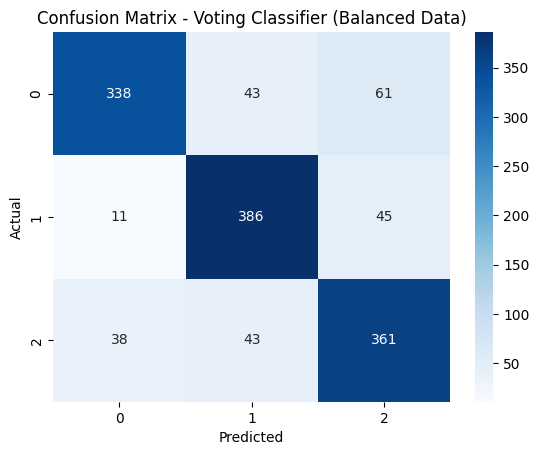

In [35]:
# Do the same for balanced data

# Initialize model
vc_bal = VotingClassifier(estimators=[
    ('logreg', LogisticRegression(max_iter=5000, random_state=42)),
    ('svc', SVC(probability=True, random_state=42)),
    ('rfc', RandomForestClassifier(random_state=42)),
    ('xgbc', XGBClassifier(random_state=42))
], voting='soft')

# Fit model
vc_bal.fit(X_train_bal, y_train_bal)

# Predict
y_pred_bal = vc_bal.predict(X_test_bal)

# Evaluate
print("Voting Classifier Performance on Balanced Test Set")
print("Macro F1 Score:", f1_score(y_test_bal, y_pred_bal, average='macro'))
print("Macro Precision:", precision_score(y_test_bal, y_pred_bal, average='macro'))
print("Macro Recall:", recall_score(y_test_bal, y_pred_bal, average='macro'))
print("Classification Report:")
print(classification_report(y_test_bal, y_pred_bal))
# Plot confusion matrix
conf_mat_bal = confusion_matrix(y_test_bal, y_pred_bal)
sns.heatmap(conf_mat_bal, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Voting Classifier (Balanced Data)')
# Save confusion matrix
plt.savefig('images/confusion_matrix_voting_classifier_balanced.png', dpi=500)

plt.show()

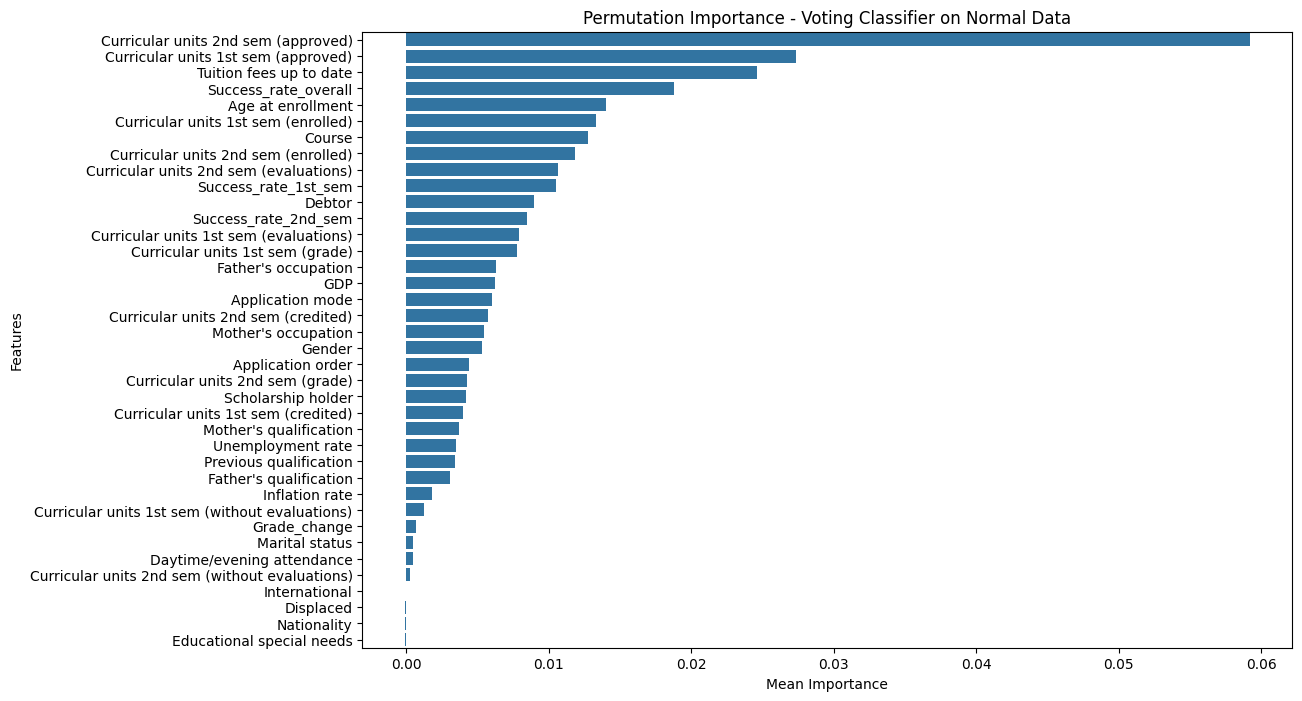

In [36]:
# Calculate permutation feature importance for Voting Classifier on normal data
result = permutation_importance(vc, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
perm_importances_vc = pd.Series(result.importances_mean, index=X_test.columns).sort_values(ascending=False)

# Visualize permutation importance
plt.figure(figsize=(12, 8))
sns.barplot(x=perm_importances_vc.values, y=perm_importances_vc.index)
plt.title('Permutation Importance - Voting Classifier on Normal Data')
plt.xlabel('Mean Importance')
plt.ylabel('Features')
# Save permutation importance plot
plt.savefig('images/permutation_importance_voting_classifier_normal.png', dpi=500)

plt.show()

Voting Classifier Performance on No Enrolled Test Set
Macro F1 Score: 0.9067703502889348
Macro Precision: 0.9195932061228769
Macro Recall: 0.8985246319546236
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.83      0.88       284
           1       0.90      0.97      0.93       442

    accuracy                           0.91       726
   macro avg       0.92      0.90      0.91       726
weighted avg       0.92      0.91      0.91       726



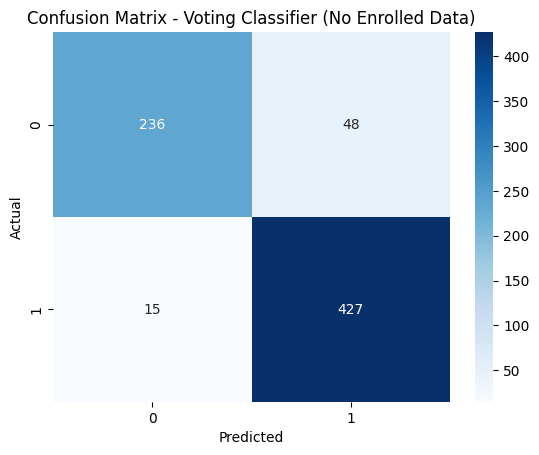

In [37]:
# Do the same for no enrolled data

# Initialize model
vc_no_enrolled = VotingClassifier(estimators=[
    ('logreg', LogisticRegression(max_iter=5000, random_state=42)),
    ('svc', SVC(probability=True, random_state=42)),
    ('rfc', RandomForestClassifier(random_state=42)),
    ('xgbc', XGBClassifier(random_state=42))
], voting='soft')

# Fit model
vc_no_enrolled.fit(X_train_no_enrolled, y_train_no_enrolled)

# Predict
y_pred_no_enrolled = vc_no_enrolled.predict(X_test_no_enrolled)

# Evaluate
print("Voting Classifier Performance on No Enrolled Test Set")
print("Macro F1 Score:", f1_score(y_test_no_enrolled, y_pred_no_enrolled, average='macro'))
print("Macro Precision:", precision_score(y_test_no_enrolled, y_pred_no_enrolled, average='macro'))
print("Macro Recall:", recall_score(y_test_no_enrolled, y_pred_no_enrolled, average='macro'))
print("Classification Report:")
print(classification_report(y_test_no_enrolled, y_pred_no_enrolled))
# Plot confusion matrix
conf_mat_no_enrolled = confusion_matrix(y_test_no_enrolled, y_pred_no_enrolled)
sns.heatmap(conf_mat_no_enrolled, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Voting Classifier (No Enrolled Data)')
# Save confusion matrix
plt.savefig('images/confusion_matrix_voting_classifier_no_enrolled.png', dpi=500)

plt.show()

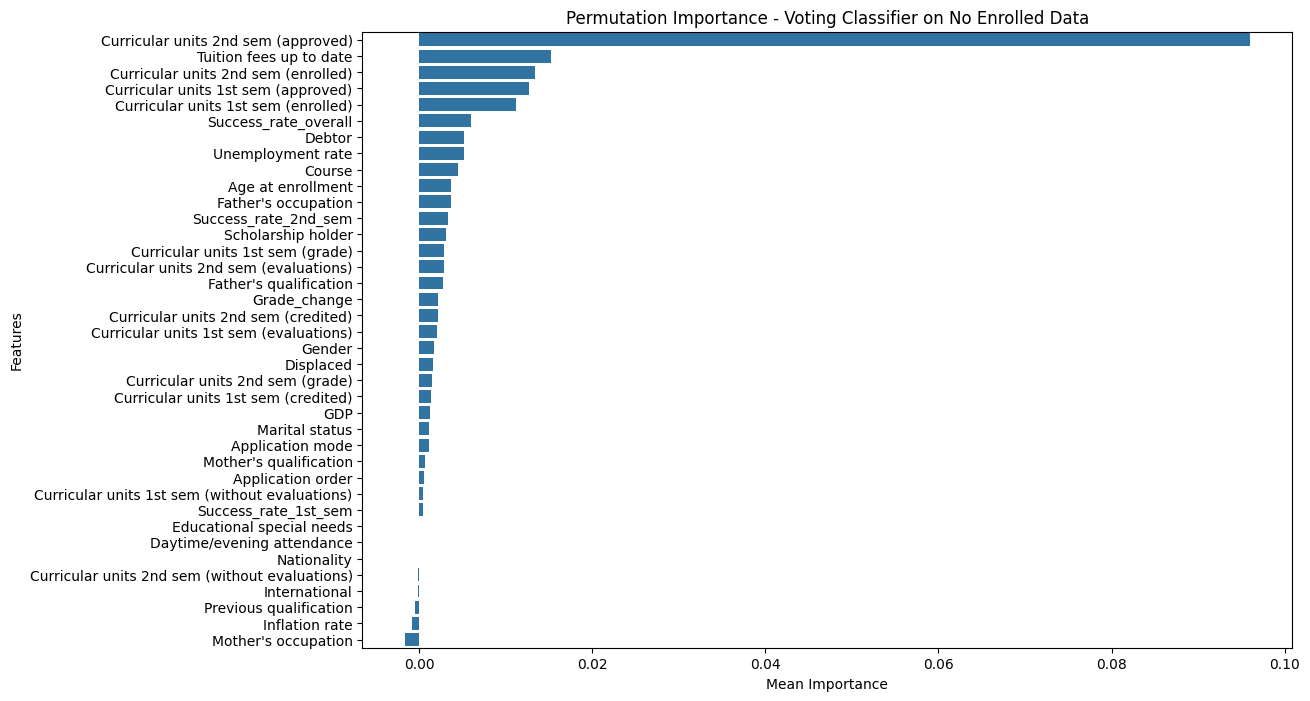

In [38]:
# Calculate permutation feature importance for Voting Classifier on no enrolled data
result_no_enrolled = permutation_importance(vc_no_enrolled, X_test_no_enrolled, y_test_no_enrolled, n_repeats=10, random_state=42, n_jobs=-1)
perm_importances_vc_no_enrolled = pd.Series(result_no_enrolled.importances_mean, index=X_test_no_enrolled.columns).sort_values(ascending=False)

# Visualize permutation importance for no enrolled data
plt.figure(figsize=(12, 8))
sns.barplot(x=perm_importances_vc_no_enrolled.values, y=perm_importances_vc_no_enrolled.index)
plt.title('Permutation Importance - Voting Classifier on No Enrolled Data')
plt.xlabel('Mean Importance')
plt.ylabel('Features')
# Save permutation importance plot
plt.savefig('images/permutation_importance_voting_classifier_no_enrolled.png', dpi=500)

plt.show()

# HYPERPARAMETER TUNING

In [39]:
def objective(trial, X_train, y_train, X_test, y_test):
    # Suggest hyperparameters (XGBoost)
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.5),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 5)
    }

    # Record starting time
    start = time.time()

    # Initialize model
    model = XGBClassifier(random_state=42, **params, verbosity=0)

    # Train model
    model.fit(X_train, y_train)

    # Evaluate on test set
    y_pred = model.predict(X_test)
    f1= f1_score(y_test, y_pred, average='macro')
    prec = precision_score(y_test, y_pred, average='macro')
    rec = recall_score(y_test, y_pred, average='macro')

    # Get time
    elapsed = time.time() - start

    # Notify immediately when a trial finishes and flush output so notebook shows it
    print(f"Trial {trial.number} finished in {elapsed:.1f}s — F1-Score: {f1:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}")
    sys.stdout.flush()

    # Clear memory
    gc.collect()

    return f1, prec, rec

In [40]:
# Create and run study
study = optuna.create_study(directions=['maximize', 'maximize', 'maximize'], study_name='XGBoost Hyperparameter Tuning Multi-Objective (Normal Data)')
start = time.time()
study.optimize(lambda trial: objective(trial, X_train, y_train, X_test, y_test), n_trials=50)
print(f"Optuna finished in {time.time() - start:.1f}s")

# Show best trials
print("Best trials:")
for i, trial in enumerate(study.best_trials):
    print(f"Trial {i}:")
    print(f"  Value: F1-Score={trial.values[0]:.4f}, Precision={trial.values[1]:.4f}, Recall={trial.values[2]:.4f}")
    print("  Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")

[I 2025-12-07 22:15:11,285] A new study created in memory with name: XGBoost Hyperparameter Tuning Multi-Objective (Normal Data)


Trial 0 finished in 0.3s — F1-Score: 0.6808, Precision: 0.6995, Recall: 0.6741


[I 2025-12-07 22:15:11,666] Trial 0 finished with values: [0.6807750174755537, 0.6995243968841328, 0.6740863949169275] and parameters: {'n_estimators': 404, 'max_depth': 16, 'learning_rate': 0.39789046231947284, 'subsample': 0.894502322069263, 'colsample_bytree': 0.8831384191236712, 'gamma': 2.954564362013274, 'reg_alpha': 2.4040287491288135, 'reg_lambda': 4.62892061412133}.


Trial 1 finished in 0.3s — F1-Score: 0.6888, Precision: 0.7052, Recall: 0.6817


[I 2025-12-07 22:15:12,105] Trial 1 finished with values: [0.6888267812562922, 0.7052211857648555, 0.6817205632840843] and parameters: {'n_estimators': 406, 'max_depth': 9, 'learning_rate': 0.4358274807897406, 'subsample': 0.6217102243206543, 'colsample_bytree': 0.7027515668468567, 'gamma': 4.712584878066493, 'reg_alpha': 4.719378347249953, 'reg_lambda': 0.398914903132791}.


Trial 2 finished in 0.3s — F1-Score: 0.6881, Precision: 0.7096, Recall: 0.6785


[I 2025-12-07 22:15:12,514] Trial 2 finished with values: [0.6880824532966185, 0.7096350741457124, 0.6785300818065666] and parameters: {'n_estimators': 350, 'max_depth': 19, 'learning_rate': 0.2069744890888835, 'subsample': 0.9358963740315875, 'colsample_bytree': 0.9050323271458348, 'gamma': 1.3551888577649756, 'reg_alpha': 0.9594972439200894, 'reg_lambda': 3.853492209617464}.


Trial 3 finished in 0.2s — F1-Score: 0.6892, Precision: 0.7095, Recall: 0.6795


[I 2025-12-07 22:15:12,769] Trial 3 finished with values: [0.6892362958793167, 0.7094948403356257, 0.6794553808904061] and parameters: {'n_estimators': 190, 'max_depth': 18, 'learning_rate': 0.20683664278614083, 'subsample': 0.795181612007631, 'colsample_bytree': 0.831109504118271, 'gamma': 2.249875725160904, 'reg_alpha': 1.2250289281233584, 'reg_lambda': 1.0626939586174555}.


Trial 4 finished in 0.4s — F1-Score: 0.6910, Precision: 0.7106, Recall: 0.6828


[I 2025-12-07 22:15:13,253] Trial 4 finished with values: [0.691027356360823, 0.7105624919390102, 0.6828067258574833] and parameters: {'n_estimators': 496, 'max_depth': 5, 'learning_rate': 0.21807091526169387, 'subsample': 0.6957551773328521, 'colsample_bytree': 0.6986240362254461, 'gamma': 1.1229791794118493, 'reg_alpha': 4.669360756680522, 'reg_lambda': 4.358949190607968}.


Trial 5 finished in 0.4s — F1-Score: 0.6873, Precision: 0.7050, Recall: 0.6798


[I 2025-12-07 22:15:13,694] Trial 5 finished with values: [0.6872995210918603, 0.7050329506115706, 0.6797901346055979] and parameters: {'n_estimators': 462, 'max_depth': 19, 'learning_rate': 0.20862563641069787, 'subsample': 0.5669431146266191, 'colsample_bytree': 0.7300044608708091, 'gamma': 3.4176285380991835, 'reg_alpha': 1.4349618915210227, 'reg_lambda': 4.251007620535546}.


Trial 6 finished in 0.1s — F1-Score: 0.6858, Precision: 0.7041, Recall: 0.6789


[I 2025-12-07 22:15:13,886] Trial 6 finished with values: [0.6857565418176347, 0.7040745536937921, 0.6788674074670854] and parameters: {'n_estimators': 122, 'max_depth': 14, 'learning_rate': 0.2636070342541175, 'subsample': 0.9503793559005519, 'colsample_bytree': 0.6936774129429661, 'gamma': 3.840493954553658, 'reg_alpha': 2.7129264030045857, 'reg_lambda': 3.037575893034094}.


Trial 7 finished in 0.3s — F1-Score: 0.6892, Precision: 0.7044, Recall: 0.6824


[I 2025-12-07 22:15:14,271] Trial 7 finished with values: [0.6891837504186494, 0.7044092889681125, 0.6823911061729762] and parameters: {'n_estimators': 398, 'max_depth': 16, 'learning_rate': 0.19308549693482485, 'subsample': 0.5838829847801681, 'colsample_bytree': 0.9400086169202303, 'gamma': 4.058714457373578, 'reg_alpha': 2.6259951964281902, 'reg_lambda': 3.5894797231161855}.


Trial 8 finished in 0.2s — F1-Score: 0.6828, Precision: 0.6995, Recall: 0.6762


[I 2025-12-07 22:15:14,588] Trial 8 finished with values: [0.6828283498209774, 0.699479235623814, 0.676185402920955] and parameters: {'n_estimators': 305, 'max_depth': 12, 'learning_rate': 0.40080003342431103, 'subsample': 0.8368508280376218, 'colsample_bytree': 0.7609889653606794, 'gamma': 4.781090434266784, 'reg_alpha': 4.688006905350728, 'reg_lambda': 3.8565896411020355}.


Trial 9 finished in 0.2s — F1-Score: 0.6873, Precision: 0.7040, Recall: 0.6795


[I 2025-12-07 22:15:14,816] Trial 9 finished with values: [0.6872774037029289, 0.7040255727924495, 0.6794541784224609] and parameters: {'n_estimators': 189, 'max_depth': 17, 'learning_rate': 0.4772112991240731, 'subsample': 0.6002173847539187, 'colsample_bytree': 0.6352315108368178, 'gamma': 4.470348715817564, 'reg_alpha': 1.0783182429343652, 'reg_lambda': 2.9730765183288828}.


Trial 10 finished in 0.6s — F1-Score: 0.6743, Precision: 0.6866, Recall: 0.6682


[I 2025-12-07 22:15:15,469] Trial 10 finished with values: [0.6743202151290921, 0.6866041366041366, 0.668222994206643] and parameters: {'n_estimators': 427, 'max_depth': 3, 'learning_rate': 0.12015886794535198, 'subsample': 0.6570274019887421, 'colsample_bytree': 0.9178652430585169, 'gamma': 0.04110863589461611, 'reg_alpha': 0.28331304995534656, 'reg_lambda': 4.065227816416018}.


Trial 11 finished in 0.4s — F1-Score: 0.6988, Precision: 0.7187, Recall: 0.6895


[I 2025-12-07 22:15:15,911] Trial 11 finished with values: [0.6988462233363624, 0.7186560309141384, 0.6895155951408003] and parameters: {'n_estimators': 449, 'max_depth': 5, 'learning_rate': 0.14048587739551746, 'subsample': 0.904234070670584, 'colsample_bytree': 0.7601588556804834, 'gamma': 2.3653928172548504, 'reg_alpha': 2.6735984423780295, 'reg_lambda': 4.111354406389545}.


Trial 12 finished in 0.4s — F1-Score: 0.6867, Precision: 0.7071, Recall: 0.6786


[I 2025-12-07 22:15:16,373] Trial 12 finished with values: [0.6867297766735829, 0.7070975918884664, 0.6786138537400829] and parameters: {'n_estimators': 431, 'max_depth': 15, 'learning_rate': 0.33110173807276816, 'subsample': 0.9367393353520233, 'colsample_bytree': 0.524647019969871, 'gamma': 3.0574369558703522, 'reg_alpha': 0.6422205462117458, 'reg_lambda': 0.9455656996210698}.


Trial 13 finished in 0.3s — F1-Score: 0.6845, Precision: 0.7033, Recall: 0.6762


[I 2025-12-07 22:15:16,789] Trial 13 finished with values: [0.6844649579747949, 0.7033351276966209, 0.6761840334435729] and parameters: {'n_estimators': 314, 'max_depth': 5, 'learning_rate': 0.09154249375673107, 'subsample': 0.6493993977876633, 'colsample_bytree': 0.6587706526025643, 'gamma': 1.3435928781787614, 'reg_alpha': 2.805212543664499, 'reg_lambda': 3.243470095501577}.


Trial 14 finished in 0.1s — F1-Score: 0.6900, Precision: 0.7079, Recall: 0.6820


[I 2025-12-07 22:15:17,005] Trial 14 finished with values: [0.6899993840359723, 0.7079170517934162, 0.6819701755883775] and parameters: {'n_estimators': 161, 'max_depth': 10, 'learning_rate': 0.44231423420543525, 'subsample': 0.7055010070244438, 'colsample_bytree': 0.6611586412249906, 'gamma': 2.7406577712158886, 'reg_alpha': 0.40674965235980687, 'reg_lambda': 4.441203892678986}.


Trial 15 finished in 0.3s — F1-Score: 0.6852, Precision: 0.7005, Recall: 0.6780


[I 2025-12-07 22:15:17,363] Trial 15 finished with values: [0.6851546823883985, 0.7005114784205694, 0.6780294877205977] and parameters: {'n_estimators': 228, 'max_depth': 20, 'learning_rate': 0.36932718044017065, 'subsample': 0.7255671969549833, 'colsample_bytree': 0.7409211089256362, 'gamma': 0.7709734086832204, 'reg_alpha': 0.49486578493522226, 'reg_lambda': 4.71125540862335}.


Trial 16 finished in 0.3s — F1-Score: 0.6840, Precision: 0.7026, Recall: 0.6772


[I 2025-12-07 22:15:17,787] Trial 16 finished with values: [0.6839824753706711, 0.7026060606060606, 0.6771905325156017] and parameters: {'n_estimators': 454, 'max_depth': 14, 'learning_rate': 0.23036211600445294, 'subsample': 0.895571938146779, 'colsample_bytree': 0.7308758333610081, 'gamma': 3.7033696715074034, 'reg_alpha': 2.0252819400338007, 'reg_lambda': 4.010180380200436}.


Trial 17 finished in 0.1s — F1-Score: 0.6849, Precision: 0.6997, Recall: 0.6783


[I 2025-12-07 22:15:17,972] Trial 17 finished with values: [0.6848965696844971, 0.6997406847968781, 0.6782818389796552] and parameters: {'n_estimators': 111, 'max_depth': 19, 'learning_rate': 0.483892848778276, 'subsample': 0.8761635580412673, 'colsample_bytree': 0.5001218597803594, 'gamma': 4.431468259652785, 'reg_alpha': 0.28928278711335076, 'reg_lambda': 2.288820980525265}.


Trial 18 finished in 0.2s — F1-Score: 0.6947, Precision: 0.7138, Recall: 0.6862


[I 2025-12-07 22:15:18,247] Trial 18 finished with values: [0.6947237163409962, 0.7138074618180719, 0.6861604757604507] and parameters: {'n_estimators': 217, 'max_depth': 5, 'learning_rate': 0.2587617670578893, 'subsample': 0.9843091328361218, 'colsample_bytree': 0.8662751873325374, 'gamma': 0.7773586507569497, 'reg_alpha': 4.063950685821361, 'reg_lambda': 2.8106617734178507}.


Trial 19 finished in 0.2s — F1-Score: 0.6953, Precision: 0.7180, Recall: 0.6878


[I 2025-12-07 22:15:18,537] Trial 19 finished with values: [0.6952553027080414, 0.7180088035682203, 0.6878375177213712] and parameters: {'n_estimators': 244, 'max_depth': 3, 'learning_rate': 0.14727682855490154, 'subsample': 0.766915500070577, 'colsample_bytree': 0.6017118629781215, 'gamma': 4.2335200555842105, 'reg_alpha': 1.1973099415661221, 'reg_lambda': 4.916212513209947}.


Trial 20 finished in 0.2s — F1-Score: 0.6879, Precision: 0.7051, Recall: 0.6796


[I 2025-12-07 22:15:18,834] Trial 20 finished with values: [0.6878744387700304, 0.7050621644474173, 0.679622757748002] and parameters: {'n_estimators': 234, 'max_depth': 11, 'learning_rate': 0.319526363782096, 'subsample': 0.5605856080716636, 'colsample_bytree': 0.7429321314137296, 'gamma': 2.5249555482213437, 'reg_alpha': 1.3537195338731296, 'reg_lambda': 3.0808789576324704}.


Trial 21 finished in 0.1s — F1-Score: 0.6955, Precision: 0.7149, Recall: 0.6882


[I 2025-12-07 22:15:19,048] Trial 21 finished with values: [0.6955230300542276, 0.7148541870316064, 0.6881746763724536] and parameters: {'n_estimators': 138, 'max_depth': 17, 'learning_rate': 0.21620776642093442, 'subsample': 0.8262185409122129, 'colsample_bytree': 0.9504054441667957, 'gamma': 4.2689232830316834, 'reg_alpha': 3.111730977421, 'reg_lambda': 0.19380177067567228}.


Trial 22 finished in 0.2s — F1-Score: 0.6811, Precision: 0.6980, Recall: 0.6745


[I 2025-12-07 22:15:19,367] Trial 22 finished with values: [0.6810745521667418, 0.6980180768465302, 0.6745085279694711] and parameters: {'n_estimators': 293, 'max_depth': 12, 'learning_rate': 0.3554899214485927, 'subsample': 0.9363060242365936, 'colsample_bytree': 0.5504077828403291, 'gamma': 4.557946770673351, 'reg_alpha': 0.10944347710572289, 'reg_lambda': 2.9265079009778283}.


Trial 23 finished in 0.2s — F1-Score: 0.6941, Precision: 0.7156, Recall: 0.6852


[I 2025-12-07 22:15:19,637] Trial 23 finished with values: [0.6941153833238118, 0.7155602119993083, 0.6852377486219384] and parameters: {'n_estimators': 224, 'max_depth': 4, 'learning_rate': 0.4475072993525042, 'subsample': 0.9241128573929374, 'colsample_bytree': 0.9211798810016502, 'gamma': 1.7197520384107823, 'reg_alpha': 1.8117830616157922, 'reg_lambda': 4.47405933584766}.


Trial 24 finished in 0.4s — F1-Score: 0.6941, Precision: 0.7139, Recall: 0.6850


[I 2025-12-07 22:15:20,087] Trial 24 finished with values: [0.6941492981444711, 0.7139480449714132, 0.684986766840263] and parameters: {'n_estimators': 497, 'max_depth': 10, 'learning_rate': 0.4140380906004122, 'subsample': 0.8094844834312478, 'colsample_bytree': 0.8860343184485804, 'gamma': 2.812303957415096, 'reg_alpha': 1.6401164592194395, 'reg_lambda': 0.646991360466887}.


Trial 25 finished in 0.5s — F1-Score: 0.6869, Precision: 0.7110, Recall: 0.6778


[I 2025-12-07 22:15:20,640] Trial 25 finished with values: [0.6869155506546698, 0.7110051778589602, 0.6777747315256498] and parameters: {'n_estimators': 316, 'max_depth': 14, 'learning_rate': 0.16713900719613922, 'subsample': 0.9481551841748664, 'colsample_bytree': 0.5247355002725003, 'gamma': 0.33148641084910613, 'reg_alpha': 2.6520211371661793, 'reg_lambda': 3.4227319321841394}.


Trial 26 finished in 0.1s — F1-Score: 0.6980, Precision: 0.7197, Recall: 0.6901


[I 2025-12-07 22:15:20,818] Trial 26 finished with values: [0.6979878774951563, 0.7196918068357094, 0.6901025331056126] and parameters: {'n_estimators': 62, 'max_depth': 6, 'learning_rate': 0.2684775918345773, 'subsample': 0.6556603042298903, 'colsample_bytree': 0.6058511223094158, 'gamma': 3.344092807156884, 'reg_alpha': 3.8523107788347155, 'reg_lambda': 0.6335497851409982}.


Trial 27 finished in 0.2s — F1-Score: 0.6930, Precision: 0.7135, Recall: 0.6852


[I 2025-12-07 22:15:21,086] Trial 27 finished with values: [0.6929721471011666, 0.7134977750920178, 0.6852391180993204] and parameters: {'n_estimators': 184, 'max_depth': 17, 'learning_rate': 0.25366734343570174, 'subsample': 0.9965925561372868, 'colsample_bytree': 0.9776772251196204, 'gamma': 4.860069831497644, 'reg_alpha': 3.341002367579593, 'reg_lambda': 0.27035536772972657}.


Trial 28 finished in 0.4s — F1-Score: 0.6877, Precision: 0.7078, Recall: 0.6809


[I 2025-12-07 22:15:21,568] Trial 28 finished with values: [0.6876630134658681, 0.7078360898363294, 0.6808776666563788] and parameters: {'n_estimators': 472, 'max_depth': 5, 'learning_rate': 0.375399486616362, 'subsample': 0.8349429271508323, 'colsample_bytree': 0.8508872578079367, 'gamma': 2.9858669532878674, 'reg_alpha': 4.4004671647464955, 'reg_lambda': 0.8407720837024968}.


Trial 29 finished in 0.3s — F1-Score: 0.6907, Precision: 0.7132, Recall: 0.6827


[I 2025-12-07 22:15:21,976] Trial 29 finished with values: [0.6906938899918277, 0.7132183469919319, 0.6827231209334038] and parameters: {'n_estimators': 379, 'max_depth': 19, 'learning_rate': 0.1406014502132163, 'subsample': 0.8662062491103979, 'colsample_bytree': 0.6005504868699971, 'gamma': 4.557689962327276, 'reg_alpha': 4.470799417827954, 'reg_lambda': 1.204305017200764}.


Trial 30 finished in 0.3s — F1-Score: 0.6773, Precision: 0.6905, Recall: 0.6714


[I 2025-12-07 22:15:22,341] Trial 30 finished with values: [0.6773167073736696, 0.6905253783269071, 0.6714055928387422] and parameters: {'n_estimators': 231, 'max_depth': 9, 'learning_rate': 0.48643220516096436, 'subsample': 0.5331763693565998, 'colsample_bytree': 0.6480991042765066, 'gamma': 1.2695250287992932, 'reg_alpha': 2.20070816027866, 'reg_lambda': 3.8264908796143198}.


Trial 31 finished in 0.4s — F1-Score: 0.6990, Precision: 0.7204, Recall: 0.6906


[I 2025-12-07 22:15:22,784] Trial 31 finished with values: [0.6989731732601777, 0.7203944510924966, 0.6906056991369085] and parameters: {'n_estimators': 378, 'max_depth': 4, 'learning_rate': 0.1580182129558116, 'subsample': 0.7532504105946257, 'colsample_bytree': 0.7609838494693276, 'gamma': 4.948276243960447, 'reg_alpha': 1.6246096061112891, 'reg_lambda': 4.999697719827222}.


Trial 32 finished in 0.1s — F1-Score: 0.6998, Precision: 0.7185, Recall: 0.6917


[I 2025-12-07 22:15:22,985] Trial 32 finished with values: [0.6998214777719803, 0.7184612189356354, 0.6916944336556349] and parameters: {'n_estimators': 98, 'max_depth': 6, 'learning_rate': 0.29106957167760694, 'subsample': 0.7073276932949438, 'colsample_bytree': 0.6324980991703928, 'gamma': 2.3136746175552703, 'reg_alpha': 2.616301146852181, 'reg_lambda': 0.7159512012229746}.


Trial 33 finished in 0.4s — F1-Score: 0.6862, Precision: 0.7022, Recall: 0.6784


[I 2025-12-07 22:15:23,452] Trial 33 finished with values: [0.6862397769437246, 0.7021823819551948, 0.6784490488278142] and parameters: {'n_estimators': 320, 'max_depth': 11, 'learning_rate': 0.1217187127453714, 'subsample': 0.7443415860138236, 'colsample_bytree': 0.6146682362059966, 'gamma': 0.9037167560470583, 'reg_alpha': 4.27165975586197, 'reg_lambda': 1.5316216451747717}.


Trial 34 finished in 0.4s — F1-Score: 0.6958, Precision: 0.7170, Recall: 0.6871


[I 2025-12-07 22:15:23,882] Trial 34 finished with values: [0.6958205222983405, 0.7169796477262097, 0.687082000431018] and parameters: {'n_estimators': 453, 'max_depth': 6, 'learning_rate': 0.3213819994122067, 'subsample': 0.8929100088621715, 'colsample_bytree': 0.8891753607500477, 'gamma': 1.1824809739435205, 'reg_alpha': 4.613643974038688, 'reg_lambda': 4.147377379207683}.


Trial 35 finished in 0.2s — F1-Score: 0.6980, Precision: 0.7171, Recall: 0.6893


[I 2025-12-07 22:15:24,138] Trial 35 finished with values: [0.698025633633779, 0.7170685640649133, 0.6893470158152591] and parameters: {'n_estimators': 205, 'max_depth': 20, 'learning_rate': 0.27148541379843794, 'subsample': 0.5799331830607121, 'colsample_bytree': 0.8390304808064997, 'gamma': 2.5271263710395573, 'reg_alpha': 2.953088763960209, 'reg_lambda': 4.252623322420368}.


Trial 36 finished in 0.4s — F1-Score: 0.6837, Precision: 0.7035, Recall: 0.6758


[I 2025-12-07 22:15:24,661] Trial 36 finished with values: [0.6837427278603748, 0.7035043682631016, 0.6758468747924908] and parameters: {'n_estimators': 359, 'max_depth': 6, 'learning_rate': 0.3946288139225078, 'subsample': 0.5733569429083563, 'colsample_bytree': 0.8147700189780046, 'gamma': 1.0035407662788347, 'reg_alpha': 2.5031725260214364, 'reg_lambda': 0.04756794194022862}.


Trial 37 finished in 0.1s — F1-Score: 0.6928, Precision: 0.7125, Recall: 0.6837


[I 2025-12-07 22:15:24,851] Trial 37 finished with values: [0.6928258427780142, 0.7124566721665836, 0.6837294529959957] and parameters: {'n_estimators': 54, 'max_depth': 4, 'learning_rate': 0.09249579649988042, 'subsample': 0.6037713306963066, 'colsample_bytree': 0.7544792540848032, 'gamma': 2.502551649804164, 'reg_alpha': 0.27691929857426356, 'reg_lambda': 0.3060658870592581}.


Trial 38 finished in 0.6s — F1-Score: 0.6782, Precision: 0.6961, Recall: 0.6717


[I 2025-12-07 22:15:25,526] Trial 38 finished with values: [0.6781776431562014, 0.6960653537961794, 0.6716540026750905] and parameters: {'n_estimators': 424, 'max_depth': 9, 'learning_rate': 0.26318766545201316, 'subsample': 0.846636189834336, 'colsample_bytree': 0.6670997315721827, 'gamma': 0.19255976920098894, 'reg_alpha': 1.2540106481264524, 'reg_lambda': 4.647329369288818}.


Trial 39 finished in 0.3s — F1-Score: 0.6958, Precision: 0.7141, Recall: 0.6873


[I 2025-12-07 22:15:25,930] Trial 39 finished with values: [0.69575316698245, 0.7140769629457413, 0.687250579756559] and parameters: {'n_estimators': 426, 'max_depth': 11, 'learning_rate': 0.4603129065793953, 'subsample': 0.6636243267130683, 'colsample_bytree': 0.8810686419237783, 'gamma': 4.529537677040995, 'reg_alpha': 1.468407146696991, 'reg_lambda': 0.3292391259611649}.


Trial 40 finished in 0.2s — F1-Score: 0.6766, Precision: 0.6947, Recall: 0.6698


[I 2025-12-07 22:15:26,255] Trial 40 finished with values: [0.676574624989513, 0.694678747133559, 0.6698111203433927] and parameters: {'n_estimators': 220, 'max_depth': 12, 'learning_rate': 0.3298631435120776, 'subsample': 0.5599952067709293, 'colsample_bytree': 0.8797700029839921, 'gamma': 1.0234329331656988, 'reg_alpha': 3.4653594414211293, 'reg_lambda': 1.6373050715549815}.


Trial 41 finished in 0.4s — F1-Score: 0.6948, Precision: 0.7153, Recall: 0.6854


[I 2025-12-07 22:15:26,740] Trial 41 finished with values: [0.694750742644943, 0.7152989090519073, 0.6854063279474794] and parameters: {'n_estimators': 427, 'max_depth': 9, 'learning_rate': 0.09341709890436306, 'subsample': 0.6985458512086338, 'colsample_bytree': 0.7934343360008782, 'gamma': 2.3240732158449506, 'reg_alpha': 2.6570318623842972, 'reg_lambda': 3.127456945959227}.


Trial 42 finished in 0.4s — F1-Score: 0.6978, Precision: 0.7131, Recall: 0.6904


[I 2025-12-07 22:15:27,174] Trial 42 finished with values: [0.6977508081098417, 0.713082095507393, 0.6903547173552332] and parameters: {'n_estimators': 485, 'max_depth': 5, 'learning_rate': 0.3327043759661982, 'subsample': 0.5280762406158435, 'colsample_bytree': 0.5273229617190319, 'gamma': 3.0724450316872747, 'reg_alpha': 3.5740532766084456, 'reg_lambda': 3.2420086007453524}.


Trial 43 finished in 0.4s — F1-Score: 0.6880, Precision: 0.7068, Recall: 0.6795


[I 2025-12-07 22:15:27,635] Trial 43 finished with values: [0.6880451241728531, 0.7067693719182305, 0.6794541784224609] and parameters: {'n_estimators': 450, 'max_depth': 6, 'learning_rate': 0.16591242784581806, 'subsample': 0.9100308092527867, 'colsample_bytree': 0.5926497723481738, 'gamma': 1.1411198459590977, 'reg_alpha': 3.814213109009116, 'reg_lambda': 2.368270261796285}.


Trial 44 finished in 0.3s — F1-Score: 0.6883, Precision: 0.7077, Recall: 0.6797


[I 2025-12-07 22:15:28,028] Trial 44 finished with values: [0.6883332561860511, 0.7077410252512851, 0.6797051602041363] and parameters: {'n_estimators': 393, 'max_depth': 15, 'learning_rate': 0.2630019204664983, 'subsample': 0.9489903344900373, 'colsample_bytree': 0.8733775805867003, 'gamma': 2.171070352805426, 'reg_alpha': 2.6220283629200574, 'reg_lambda': 3.9777914792055853}.


Trial 45 finished in 0.2s — F1-Score: 0.7024, Precision: 0.7272, Recall: 0.6924


[I 2025-12-07 22:15:28,343] Trial 45 finished with values: [0.7024099980333492, 0.7271621257741548, 0.6924485814686062] and parameters: {'n_estimators': 301, 'max_depth': 18, 'learning_rate': 0.3582018895857187, 'subsample': 0.953930672509911, 'colsample_bytree': 0.8723904522471324, 'gamma': 1.2587068850900895, 'reg_alpha': 3.013394643846476, 'reg_lambda': 4.837007144290134}.


Trial 46 finished in 0.3s — F1-Score: 0.6837, Precision: 0.7017, Recall: 0.6764


[I 2025-12-07 22:15:28,728] Trial 46 finished with values: [0.6836811950222721, 0.7017461144610703, 0.6763514103011689] and parameters: {'n_estimators': 390, 'max_depth': 14, 'learning_rate': 0.4104809377986959, 'subsample': 0.6966734942054946, 'colsample_bytree': 0.6013433409794998, 'gamma': 1.7117581620069078, 'reg_alpha': 3.2394950598928625, 'reg_lambda': 2.6568918607746235}.


Trial 47 finished in 0.3s — F1-Score: 0.6915, Precision: 0.7095, Recall: 0.6842


[I 2025-12-07 22:15:29,054] Trial 47 finished with values: [0.6914725314856499, 0.709469789417295, 0.6841503835805941] and parameters: {'n_estimators': 258, 'max_depth': 16, 'learning_rate': 0.08873885869780604, 'subsample': 0.6462609379686753, 'colsample_bytree': 0.8262216275879871, 'gamma': 2.731938161762507, 'reg_alpha': 3.3018780372238794, 'reg_lambda': 0.025906505303971428}.


Trial 48 finished in 0.1s — F1-Score: 0.6951, Precision: 0.7133, Recall: 0.6866


[I 2025-12-07 22:15:29,232] Trial 48 finished with values: [0.6951418061038083, 0.7133464825772519, 0.6865800368676672] and parameters: {'n_estimators': 105, 'max_depth': 12, 'learning_rate': 0.36123380394491, 'subsample': 0.7157818162577223, 'colsample_bytree': 0.851624185017746, 'gamma': 3.3776139142656665, 'reg_alpha': 0.26762762681639407, 'reg_lambda': 4.660130563296853}.


Trial 49 finished in 0.3s — F1-Score: 0.6850, Precision: 0.7007, Recall: 0.6780


[I 2025-12-07 22:15:29,588] Trial 49 finished with values: [0.6849709889393941, 0.7007168254238795, 0.6780282852526526] and parameters: {'n_estimators': 263, 'max_depth': 18, 'learning_rate': 0.32866770057003303, 'subsample': 0.595001638492838, 'colsample_bytree': 0.7469419496099532, 'gamma': 0.9735734333688723, 'reg_alpha': 3.396784945331431, 'reg_lambda': 1.8228272158490872}.


Optuna finished in 18.3s
Best trials:
Trial 0:
  Value: F1-Score=0.7024, Precision=0.7272, Recall=0.6924
  Params: 
    n_estimators: 301
    max_depth: 18
    learning_rate: 0.3582018895857187
    subsample: 0.953930672509911
    colsample_bytree: 0.8723904522471324
    gamma: 1.2587068850900895
    reg_alpha: 3.013394643846476
    reg_lambda: 4.837007144290134


XGBoost Classifier Performance on Test Set with Best Hyperparameters
Macro F1 Score: 0.7024099980333492
Macro Precision: 0.7271621257741548
Macro Recall: 0.6924485814686062
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.77      0.80       284
           1       0.80      0.93      0.86       442
           2       0.56      0.38      0.45       159

    accuracy                           0.78       885
   macro avg       0.73      0.69      0.70       885
weighted avg       0.76      0.78      0.77       885



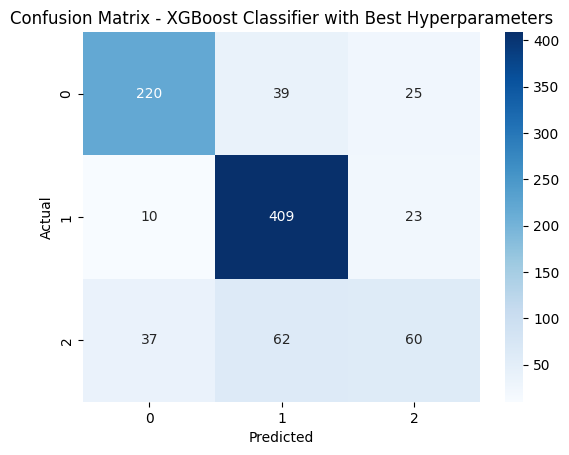

In [41]:
# Get best trial
best_trial = study.best_trials[0]
best_params = best_trial.params

# Train final model with best hyperparameters
final_model = XGBClassifier(random_state=42, **best_params, verbosity=0)
final_model.fit(X_train, y_train)
# Predict
y_pred = final_model.predict(X_test)

# Evaluate
print("XGBoost Classifier Performance on Test Set with Best Hyperparameters")
print("Macro F1 Score:", f1_score(y_test, y_pred, average='macro'))
print("Macro Precision:", precision_score(y_test, y_pred, average='macro'))
print("Macro Recall:", recall_score(y_test, y_pred, average='macro'))
print("Classification Report:")
print(classification_report(y_test, y_pred))
# Plot confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - XGBoost Classifier with Best Hyperparameters')
# Save confusion matrix
plt.savefig('images/confusion_matrix_ht_xgboost.png', dpi=500)

plt.show()

,Feature,Importance
36,Success_rate_overall,0.304653
35,Success_rate_2nd_sem,0.144710
28,Curricular units 2nd sem (approved),0.064969
14,Tuition fees up to date,0.050083
20,Curricular units 1st sem (enrolled),0.046991
16,Scholarship holder,0.018947
21,Curricular units 1st sem (evaluations),0.017217
13,Debtor,0.016644
17,Age at enrollment,0.016640
3,Course,0.016313


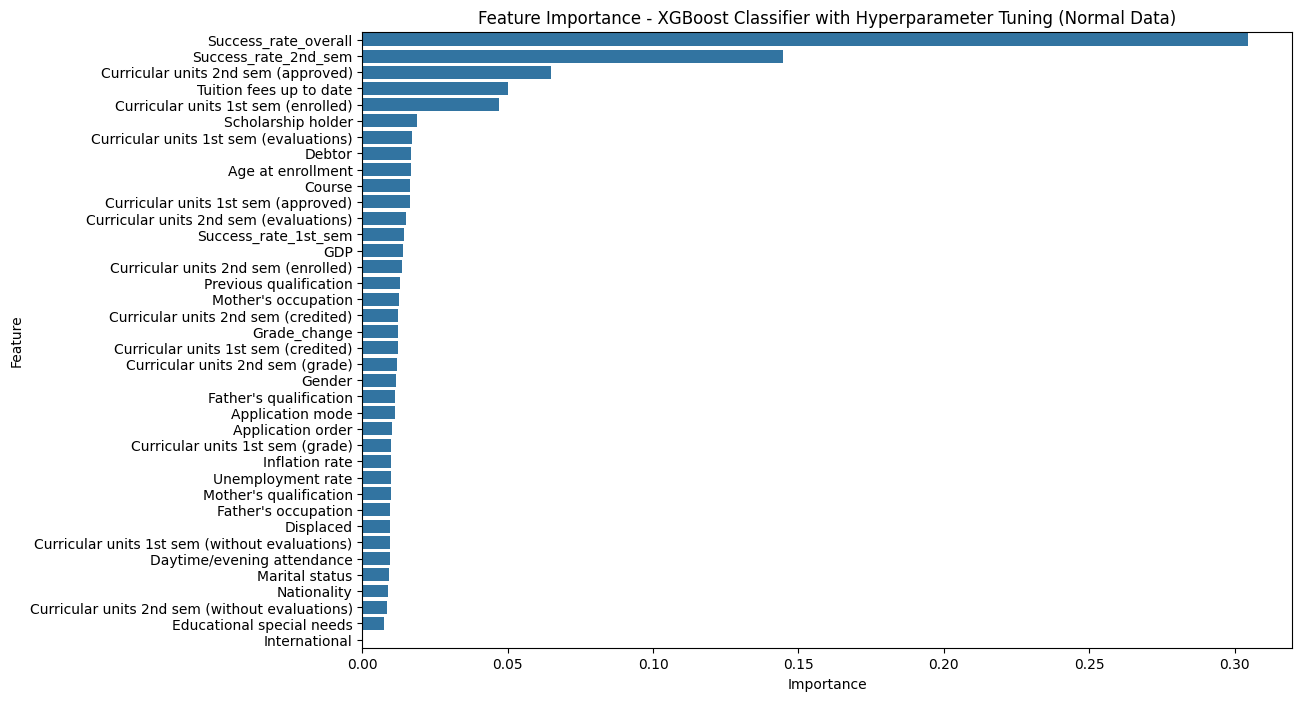

In [42]:
# Check feature importance for XGBoost with hyperparameter tuning on normal data
importances_xgb_ht = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': final_model.feature_importances_
})
importances_xgb_ht = importances_xgb_ht.sort_values(by='Importance', ascending=False)
display(importances_xgb_ht)

# Visualize feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importances_xgb_ht)
plt.title('Feature Importance - XGBoost Classifier with Hyperparameter Tuning (Normal Data)')
# Save feature importance plot
plt.savefig('images/feature_importance_xgboost_ht_normal.png', dpi=500)

plt.show()

In [43]:
# Create and run study
study = optuna.create_study(directions=['maximize', 'maximize', 'maximize'], study_name='XGBoost Hyperparameter Tuning Multi-Objective (Balanced Data)')
start = time.time()
study.optimize(lambda trial: objective(trial, X_train_bal, y_train_bal, X_test_bal, y_test_bal), n_trials=50)
print(f"Optuna finished in {time.time() - start:.1f}s")

# Show best trials
print("Best trials:")
for i, trial in enumerate(study.best_trials):
    print(f"Trial {i}:")
    print(f"  Value: F1-Score={trial.values[0]:.4f}, Precision={trial.values[1]:.4f}, Recall={trial.values[2]:.4f}")
    print("  Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")

[I 2025-12-07 22:15:30,827] A new study created in memory with name: XGBoost Hyperparameter Tuning Multi-Objective (Balanced Data)


Trial 0 finished in 0.2s — F1-Score: 0.7909, Precision: 0.7941, Recall: 0.7911


[I 2025-12-07 22:15:31,078] Trial 0 finished with values: [0.7909472469427926, 0.794077060953958, 0.7911010558069381] and parameters: {'n_estimators': 187, 'max_depth': 17, 'learning_rate': 0.49657887777444965, 'subsample': 0.9727129514641969, 'colsample_bytree': 0.574416753919224, 'gamma': 1.574815830268765, 'reg_alpha': 3.5844692282178503, 'reg_lambda': 2.098918401148615}.


Trial 1 finished in 0.5s — F1-Score: 0.7932, Precision: 0.7946, Recall: 0.7934


[I 2025-12-07 22:15:31,694] Trial 1 finished with values: [0.793216855230784, 0.7946351524402105, 0.7933634992458521] and parameters: {'n_estimators': 462, 'max_depth': 14, 'learning_rate': 0.09975847716595089, 'subsample': 0.912824940513856, 'colsample_bytree': 0.9741572683361734, 'gamma': 2.80297350010916, 'reg_alpha': 1.6613442958657028, 'reg_lambda': 4.471678825788514}.


Trial 2 finished in 0.8s — F1-Score: 0.8225, Precision: 0.8245, Recall: 0.8228


[I 2025-12-07 22:15:32,575] Trial 2 finished with values: [0.8225333556959037, 0.8244718048205613, 0.8227752639517346] and parameters: {'n_estimators': 396, 'max_depth': 4, 'learning_rate': 0.20567084286466664, 'subsample': 0.6297204220411775, 'colsample_bytree': 0.9620395929446149, 'gamma': 0.183942857722052, 'reg_alpha': 2.6496757787031, 'reg_lambda': 0.1972711886410322}.


Trial 3 finished in 0.4s — F1-Score: 0.7918, Precision: 0.7933, Recall: 0.7919


[I 2025-12-07 22:15:33,085] Trial 3 finished with values: [0.7917897311796729, 0.7932695262072685, 0.7918552036199095] and parameters: {'n_estimators': 462, 'max_depth': 8, 'learning_rate': 0.4703548073474304, 'subsample': 0.6655155283730858, 'colsample_bytree': 0.572353635785338, 'gamma': 4.431858057854537, 'reg_alpha': 2.704339113401559, 'reg_lambda': 4.898749593006088}.


Trial 4 finished in 0.3s — F1-Score: 0.7829, Precision: 0.7847, Recall: 0.7828


[I 2025-12-07 22:15:33,443] Trial 4 finished with values: [0.7828922534915908, 0.7846697249682325, 0.7828054298642534] and parameters: {'n_estimators': 295, 'max_depth': 9, 'learning_rate': 0.34297978054477285, 'subsample': 0.535106758338658, 'colsample_bytree': 0.5807112125603486, 'gamma': 4.904496164884803, 'reg_alpha': 4.041278169226866, 'reg_lambda': 3.3212228673066373}.


Trial 5 finished in 0.2s — F1-Score: 0.7907, Precision: 0.7920, Recall: 0.7911


[I 2025-12-07 22:15:33,687] Trial 5 finished with values: [0.7907411753206673, 0.7919928704358994, 0.7911010558069381] and parameters: {'n_estimators': 143, 'max_depth': 14, 'learning_rate': 0.4120165297251046, 'subsample': 0.9985635668507196, 'colsample_bytree': 0.9838308702683332, 'gamma': 2.1794738774962568, 'reg_alpha': 3.7040159821320184, 'reg_lambda': 3.5220485408180773}.


Trial 6 finished in 0.1s — F1-Score: 0.7872, Precision: 0.7888, Recall: 0.7873


[I 2025-12-07 22:15:33,842] Trial 6 finished with values: [0.7872390236311871, 0.7887819760337016, 0.7873303167420814] and parameters: {'n_estimators': 53, 'max_depth': 11, 'learning_rate': 0.4556599752790481, 'subsample': 0.773271370860996, 'colsample_bytree': 0.9231727341554794, 'gamma': 4.329059131939659, 'reg_alpha': 3.092854160621181, 'reg_lambda': 2.6839915349261227}.


Trial 7 finished in 0.3s — F1-Score: 0.8052, Precision: 0.8075, Recall: 0.8054


[I 2025-12-07 22:15:34,189] Trial 7 finished with values: [0.8052176060249964, 0.8074971945793402, 0.8054298642533936] and parameters: {'n_estimators': 170, 'max_depth': 10, 'learning_rate': 0.1317314138993104, 'subsample': 0.7448802154626379, 'colsample_bytree': 0.8169830595922942, 'gamma': 1.5418671444786158, 'reg_alpha': 2.3890945045925878, 'reg_lambda': 3.271530948033971}.


Trial 8 finished in 0.1s — F1-Score: 0.7970, Precision: 0.7994, Recall: 0.7971


[I 2025-12-07 22:15:34,396] Trial 8 finished with values: [0.7969731545063791, 0.7994211494088371, 0.7971342383107088] and parameters: {'n_estimators': 111, 'max_depth': 7, 'learning_rate': 0.3331850054666726, 'subsample': 0.7279975657328923, 'colsample_bytree': 0.6131785754596395, 'gamma': 2.7371056868505104, 'reg_alpha': 2.6016380365473712, 'reg_lambda': 1.8983057540283026}.


Trial 9 finished in 0.2s — F1-Score: 0.7969, Precision: 0.7991, Recall: 0.7971


[I 2025-12-07 22:15:34,656] Trial 9 finished with values: [0.7968989340763205, 0.799088485298863, 0.7971342383107088] and parameters: {'n_estimators': 138, 'max_depth': 16, 'learning_rate': 0.40146924699334724, 'subsample': 0.596218842266842, 'colsample_bytree': 0.9951901974919938, 'gamma': 2.8686047095099445, 'reg_alpha': 0.17580166726710145, 'reg_lambda': 3.716218973747641}.


Trial 10 finished in 0.3s — F1-Score: 0.8006, Precision: 0.8028, Recall: 0.8009


[I 2025-12-07 22:15:35,078] Trial 10 finished with values: [0.800632703811856, 0.8027573154920363, 0.8009049773755655] and parameters: {'n_estimators': 358, 'max_depth': 20, 'learning_rate': 0.25624808541176575, 'subsample': 0.7712971065517258, 'colsample_bytree': 0.5439551772022251, 'gamma': 2.4622355181951763, 'reg_alpha': 0.6696701336967309, 'reg_lambda': 3.788098749957779}.


Trial 11 finished in 0.2s — F1-Score: 0.8012, Precision: 0.8036, Recall: 0.8017


[I 2025-12-07 22:15:35,360] Trial 11 finished with values: [0.8011981079105014, 0.8036137721944178, 0.8016591251885369] and parameters: {'n_estimators': 154, 'max_depth': 12, 'learning_rate': 0.4032626296364723, 'subsample': 0.7492644916106066, 'colsample_bytree': 0.8767383557206878, 'gamma': 1.224017302180311, 'reg_alpha': 2.785060613274588, 'reg_lambda': 4.975460182120688}.


Trial 12 finished in 0.5s — F1-Score: 0.8015, Precision: 0.8042, Recall: 0.8017


[I 2025-12-07 22:15:35,905] Trial 12 finished with values: [0.8015178856513411, 0.8042209801863575, 0.8016591251885369] and parameters: {'n_estimators': 420, 'max_depth': 19, 'learning_rate': 0.11130890032924531, 'subsample': 0.9030672235941053, 'colsample_bytree': 0.782607998355122, 'gamma': 3.4770282201430076, 'reg_alpha': 0.7725503897609215, 'reg_lambda': 0.735321432854803}.


Trial 13 finished in 0.4s — F1-Score: 0.8037, Precision: 0.8058, Recall: 0.8039


[I 2025-12-07 22:15:36,413] Trial 13 finished with values: [0.803700530322972, 0.8058114729772708, 0.8039215686274509] and parameters: {'n_estimators': 332, 'max_depth': 13, 'learning_rate': 0.10167790551581854, 'subsample': 0.92802518883109, 'colsample_bytree': 0.7278719807210694, 'gamma': 1.9048930321021245, 'reg_alpha': 3.0275062829658497, 'reg_lambda': 0.10500698442338419}.


Trial 14 finished in 0.3s — F1-Score: 0.7925, Precision: 0.7943, Recall: 0.7926


[I 2025-12-07 22:15:36,810] Trial 14 finished with values: [0.7925162836883155, 0.7943052555795536, 0.7926093514328808] and parameters: {'n_estimators': 347, 'max_depth': 15, 'learning_rate': 0.3230040686461527, 'subsample': 0.8426722018178588, 'colsample_bytree': 0.7501121271255925, 'gamma': 4.008815036779525, 'reg_alpha': 4.147773434166303, 'reg_lambda': 1.2735154291555573}.


Trial 15 finished in 0.2s — F1-Score: 0.7969, Precision: 0.7986, Recall: 0.7971


[I 2025-12-07 22:15:37,091] Trial 15 finished with values: [0.7969212908960118, 0.7985615712537467, 0.7971342383107088] and parameters: {'n_estimators': 122, 'max_depth': 18, 'learning_rate': 0.39948252885125385, 'subsample': 0.8015525491236288, 'colsample_bytree': 0.8808470842972931, 'gamma': 2.7044067902960855, 'reg_alpha': 2.7566961236254923, 'reg_lambda': 2.2601634100807875}.


Trial 16 finished in 0.2s — F1-Score: 0.7955, Precision: 0.7968, Recall: 0.7956


[I 2025-12-07 22:15:37,407] Trial 16 finished with values: [0.7955013203218245, 0.7967635352818307, 0.7956259426847662] and parameters: {'n_estimators': 215, 'max_depth': 13, 'learning_rate': 0.3341102293947876, 'subsample': 0.7371121940933606, 'colsample_bytree': 0.835073215933543, 'gamma': 3.474088780982801, 'reg_alpha': 2.792148787378671, 'reg_lambda': 3.7960757128109672}.


Trial 17 finished in 0.5s — F1-Score: 0.8036, Precision: 0.8057, Recall: 0.8039


[I 2025-12-07 22:15:37,951] Trial 17 finished with values: [0.8035522390008553, 0.8056755158684296, 0.8039215686274509] and parameters: {'n_estimators': 398, 'max_depth': 12, 'learning_rate': 0.2251926510672304, 'subsample': 0.6346032305176426, 'colsample_bytree': 0.8876062433226529, 'gamma': 2.0248721227509883, 'reg_alpha': 1.1994925695838266, 'reg_lambda': 1.0652707877987138}.


Trial 18 finished in 0.3s — F1-Score: 0.7970, Precision: 0.7989, Recall: 0.7971


[I 2025-12-07 22:15:38,311] Trial 18 finished with values: [0.7969956122283062, 0.7988593609215832, 0.7971342383107088] and parameters: {'n_estimators': 248, 'max_depth': 15, 'learning_rate': 0.1565305538057019, 'subsample': 0.8561441686897862, 'colsample_bytree': 0.8656386060706276, 'gamma': 4.808437155044106, 'reg_alpha': 0.8570103612162311, 'reg_lambda': 3.8027013167381902}.


Trial 19 finished in 0.3s — F1-Score: 0.8021, Precision: 0.8041, Recall: 0.8024


[I 2025-12-07 22:15:38,734] Trial 19 finished with values: [0.8021050878991037, 0.8040806370754113, 0.8024132730015082] and parameters: {'n_estimators': 321, 'max_depth': 8, 'learning_rate': 0.41204935649735974, 'subsample': 0.5899465094650149, 'colsample_bytree': 0.7095671608520668, 'gamma': 3.218270579081834, 'reg_alpha': 1.8416410805966876, 'reg_lambda': 3.9334397988335996}.


Trial 20 finished in 0.2s — F1-Score: 0.7843, Precision: 0.7862, Recall: 0.7843


[I 2025-12-07 22:15:39,005] Trial 20 finished with values: [0.7843328599196925, 0.7862174702691944, 0.7843137254901961] and parameters: {'n_estimators': 193, 'max_depth': 5, 'learning_rate': 0.4791746581703314, 'subsample': 0.6455779390698967, 'colsample_bytree': 0.8146879288721705, 'gamma': 3.668739634925422, 'reg_alpha': 2.5184080617644033, 'reg_lambda': 0.7441250967460539}.


Trial 21 finished in 0.5s — F1-Score: 0.7995, Precision: 0.8020, Recall: 0.8002


[I 2025-12-07 22:15:39,551] Trial 21 finished with values: [0.79949464803697, 0.8019592608082736, 0.8001508295625942] and parameters: {'n_estimators': 451, 'max_depth': 7, 'learning_rate': 0.4003640209525529, 'subsample': 0.811550449659263, 'colsample_bytree': 0.5937178189133427, 'gamma': 1.8134169644133507, 'reg_alpha': 0.3293738315809852, 'reg_lambda': 1.9217818278194876}.


Trial 22 finished in 0.3s — F1-Score: 0.7939, Precision: 0.7955, Recall: 0.7941


[I 2025-12-07 22:15:39,959] Trial 22 finished with values: [0.7939421706609631, 0.7955028569256472, 0.7941176470588235] and parameters: {'n_estimators': 337, 'max_depth': 6, 'learning_rate': 0.44827696801871286, 'subsample': 0.9768349981126043, 'colsample_bytree': 0.9170914192107039, 'gamma': 3.895159202379615, 'reg_alpha': 2.3524658517622417, 'reg_lambda': 3.2643968374805854}.


Trial 23 finished in 0.3s — F1-Score: 0.7970, Precision: 0.7983, Recall: 0.7971


[I 2025-12-07 22:15:40,320] Trial 23 finished with values: [0.7969717482751135, 0.7983057005316957, 0.7971342383107088] and parameters: {'n_estimators': 267, 'max_depth': 20, 'learning_rate': 0.20863948092050066, 'subsample': 0.9929590399170731, 'colsample_bytree': 0.8212940797383733, 'gamma': 2.078000330729136, 'reg_alpha': 4.12968314149553, 'reg_lambda': 3.4006235198896704}.


Trial 24 finished in 0.4s — F1-Score: 0.7962, Precision: 0.7979, Recall: 0.7964


[I 2025-12-07 22:15:40,792] Trial 24 finished with values: [0.7961631945954987, 0.7978813496062404, 0.7963800904977375] and parameters: {'n_estimators': 234, 'max_depth': 12, 'learning_rate': 0.06271178026584173, 'subsample': 0.5815547255928406, 'colsample_bytree': 0.9905801763532645, 'gamma': 2.681900533922941, 'reg_alpha': 3.5067745056455344, 'reg_lambda': 2.0066388980454732}.


Trial 25 finished in 0.2s — F1-Score: 0.7957, Precision: 0.7979, Recall: 0.7956


[I 2025-12-07 22:15:41,028] Trial 25 finished with values: [0.7957340762218811, 0.7979346441111789, 0.7956259426847662] and parameters: {'n_estimators': 110, 'max_depth': 18, 'learning_rate': 0.2628187786620049, 'subsample': 0.7809359291273178, 'colsample_bytree': 0.9853204766360242, 'gamma': 4.844457376052982, 'reg_alpha': 1.1400875687456584, 'reg_lambda': 2.2132138648530675}.


Trial 26 finished in 0.3s — F1-Score: 0.7994, Precision: 0.8015, Recall: 0.7994


[I 2025-12-07 22:15:41,437] Trial 26 finished with values: [0.7994162175675568, 0.8015270974271989, 0.7993966817496229] and parameters: {'n_estimators': 345, 'max_depth': 8, 'learning_rate': 0.3804727892356546, 'subsample': 0.8381002597457273, 'colsample_bytree': 0.6645596131097516, 'gamma': 2.105978902132692, 'reg_alpha': 1.3756461371268025, 'reg_lambda': 4.051064553825332}.


Trial 27 finished in 0.3s — F1-Score: 0.8188, Precision: 0.8215, Recall: 0.8190


[I 2025-12-07 22:15:41,838] Trial 27 finished with values: [0.8188085092622783, 0.8214525028824701, 0.8190045248868777] and parameters: {'n_estimators': 118, 'max_depth': 11, 'learning_rate': 0.2199368394383407, 'subsample': 0.581520396773866, 'colsample_bytree': 0.8131110485292234, 'gamma': 0.4782595232264203, 'reg_alpha': 3.659472313284582, 'reg_lambda': 0.7186824495084965}.


Trial 28 finished in 0.3s — F1-Score: 0.7958, Precision: 0.7987, Recall: 0.7956


[I 2025-12-07 22:15:42,188] Trial 28 finished with values: [0.7957818211262403, 0.7986689796617158, 0.7956259426847662] and parameters: {'n_estimators': 182, 'max_depth': 4, 'learning_rate': 0.06094291327499138, 'subsample': 0.7267754428840193, 'colsample_bytree': 0.5370157826773898, 'gamma': 2.8374394695518363, 'reg_alpha': 3.5726700265649054, 'reg_lambda': 3.0012027143940396}.


Trial 29 finished in 0.4s — F1-Score: 0.7933, Precision: 0.7951, Recall: 0.7934


[I 2025-12-07 22:15:42,666] Trial 29 finished with values: [0.7932579167362791, 0.7951471922710335, 0.7933634992458521] and parameters: {'n_estimators': 385, 'max_depth': 19, 'learning_rate': 0.15645405279556285, 'subsample': 0.5291462691933226, 'colsample_bytree': 0.7994845887081247, 'gamma': 2.748307888585333, 'reg_alpha': 3.2339392105025437, 'reg_lambda': 0.6377179573608199}.


Trial 30 finished in 0.1s — F1-Score: 0.7963, Precision: 0.7988, Recall: 0.7964


[I 2025-12-07 22:15:42,843] Trial 30 finished with values: [0.7962683425306136, 0.79875927997694, 0.7963800904977375] and parameters: {'n_estimators': 62, 'max_depth': 16, 'learning_rate': 0.44916114724353207, 'subsample': 0.9372289945414025, 'colsample_bytree': 0.5656649493817909, 'gamma': 2.7194678808884856, 'reg_alpha': 0.01750995245539122, 'reg_lambda': 1.6435925326060512}.


Trial 31 finished in 0.3s — F1-Score: 0.7947, Precision: 0.7962, Recall: 0.7949


[I 2025-12-07 22:15:43,252] Trial 31 finished with values: [0.794671611193846, 0.7962400659769081, 0.7948717948717948] and parameters: {'n_estimators': 346, 'max_depth': 7, 'learning_rate': 0.4962833872418181, 'subsample': 0.7721928033702241, 'colsample_bytree': 0.998076680129441, 'gamma': 2.9249934500106445, 'reg_alpha': 4.283740632180139, 'reg_lambda': 4.1910906061211755}.


Trial 32 finished in 0.6s — F1-Score: 0.8045, Precision: 0.8074, Recall: 0.8047


[I 2025-12-07 22:15:43,921] Trial 32 finished with values: [0.8044770148320707, 0.8073976481608239, 0.8046757164404222] and parameters: {'n_estimators': 360, 'max_depth': 3, 'learning_rate': 0.2213729882183959, 'subsample': 0.6042853318457992, 'colsample_bytree': 0.6809348462735179, 'gamma': 0.05337802434221495, 'reg_alpha': 4.877660594966937, 'reg_lambda': 0.683026532052533}.


Trial 33 finished in 0.4s — F1-Score: 0.7897, Precision: 0.7918, Recall: 0.7896


[I 2025-12-07 22:15:44,382] Trial 33 finished with values: [0.7897203650868971, 0.7918269558917527, 0.7895927601809954] and parameters: {'n_estimators': 296, 'max_depth': 12, 'learning_rate': 0.05155649029066407, 'subsample': 0.5731264308535865, 'colsample_bytree': 0.7260704851430833, 'gamma': 4.2893691886904675, 'reg_alpha': 3.3628634212334103, 'reg_lambda': 4.675856901651939}.


Trial 34 finished in 0.2s — F1-Score: 0.8093, Precision: 0.8126, Recall: 0.8092


[I 2025-12-07 22:15:44,626] Trial 34 finished with values: [0.809341814198349, 0.8126097612663662, 0.8092006033182505] and parameters: {'n_estimators': 86, 'max_depth': 8, 'learning_rate': 0.42001428879431946, 'subsample': 0.9429976518028843, 'colsample_bytree': 0.6889879345760499, 'gamma': 0.497144425107347, 'reg_alpha': 1.4489348988999928, 'reg_lambda': 4.973970975495662}.


Trial 35 finished in 0.4s — F1-Score: 0.8209, Precision: 0.8227, Recall: 0.8213


[I 2025-12-07 22:15:45,106] Trial 35 finished with values: [0.8209011600847042, 0.822736032245366, 0.8212669683257919] and parameters: {'n_estimators': 276, 'max_depth': 13, 'learning_rate': 0.4378136271801568, 'subsample': 0.9432049742370185, 'colsample_bytree': 0.7288061894887178, 'gamma': 0.6716468398790959, 'reg_alpha': 0.05484727709854087, 'reg_lambda': 3.985898568615701}.


Trial 36 finished in 0.4s — F1-Score: 0.8159, Precision: 0.8175, Recall: 0.8160


[I 2025-12-07 22:15:45,539] Trial 36 finished with values: [0.8159038598259812, 0.8174742470708501, 0.8159879336349923] and parameters: {'n_estimators': 246, 'max_depth': 13, 'learning_rate': 0.42849345877290496, 'subsample': 0.9042080357119505, 'colsample_bytree': 0.7751322335808747, 'gamma': 0.3588170676521163, 'reg_alpha': 2.1111502911442215, 'reg_lambda': 2.6478398843231563}.


Trial 37 finished in 0.5s — F1-Score: 0.8050, Precision: 0.8071, Recall: 0.8054


[I 2025-12-07 22:15:46,135] Trial 37 finished with values: [0.8050115441761144, 0.8071384726577766, 0.8054298642533936] and parameters: {'n_estimators': 462, 'max_depth': 18, 'learning_rate': 0.33665169161426983, 'subsample': 0.6306722569999694, 'colsample_bytree': 0.602236263420304, 'gamma': 2.44997235964032, 'reg_alpha': 0.5099584447440852, 'reg_lambda': 0.2921978330712549}.


Trial 38 finished in 0.3s — F1-Score: 0.8009, Precision: 0.8037, Recall: 0.8009


[I 2025-12-07 22:15:46,479] Trial 38 finished with values: [0.8009464433100854, 0.803730947277851, 0.8009049773755655] and parameters: {'n_estimators': 138, 'max_depth': 9, 'learning_rate': 0.10076980199636484, 'subsample': 0.852773228285468, 'colsample_bytree': 0.8476622675757655, 'gamma': 2.2133463573632723, 'reg_alpha': 0.8882332619597955, 'reg_lambda': 4.683071106990202}.


Trial 39 finished in 0.5s — F1-Score: 0.8135, Precision: 0.8163, Recall: 0.8137


[I 2025-12-07 22:15:47,018] Trial 39 finished with values: [0.8135382790072073, 0.8163328397720645, 0.8137254901960783] and parameters: {'n_estimators': 456, 'max_depth': 13, 'learning_rate': 0.3575794623665732, 'subsample': 0.9319241055235457, 'colsample_bytree': 0.9304705676114012, 'gamma': 0.7418811644570317, 'reg_alpha': 4.045355982945305, 'reg_lambda': 3.2166572216684868}.


Trial 40 finished in 0.3s — F1-Score: 0.7956, Precision: 0.7975, Recall: 0.7956


[I 2025-12-07 22:15:47,402] Trial 40 finished with values: [0.7955506126765931, 0.7974687451767247, 0.7956259426847662] and parameters: {'n_estimators': 282, 'max_depth': 17, 'learning_rate': 0.18074469667235737, 'subsample': 0.599182826551691, 'colsample_bytree': 0.5236638453716072, 'gamma': 3.1778772139872977, 'reg_alpha': 4.351649064582993, 'reg_lambda': 3.951048379235253}.


Trial 41 finished in 0.3s — F1-Score: 0.8109, Precision: 0.8125, Recall: 0.8115


[I 2025-12-07 22:15:47,780] Trial 41 finished with values: [0.810944885102824, 0.8125020836146165, 0.8114630467571643] and parameters: {'n_estimators': 164, 'max_depth': 12, 'learning_rate': 0.20323781461493678, 'subsample': 0.7388496813092325, 'colsample_bytree': 0.954080719818377, 'gamma': 0.7298941883290899, 'reg_alpha': 4.689544617924333, 'reg_lambda': 1.9722663573881145}.


Trial 42 finished in 0.3s — F1-Score: 0.7931, Precision: 0.7950, Recall: 0.7934


[I 2025-12-07 22:15:48,152] Trial 42 finished with values: [0.793113045952324, 0.7950382923637914, 0.7933634992458521] and parameters: {'n_estimators': 290, 'max_depth': 17, 'learning_rate': 0.4321380341580086, 'subsample': 0.8870847556039926, 'colsample_bytree': 0.5005239387863959, 'gamma': 4.379951794967058, 'reg_alpha': 1.2138286316602924, 'reg_lambda': 3.563738057125251}.


Trial 43 finished in 0.4s — F1-Score: 0.7989, Precision: 0.8016, Recall: 0.7994


[I 2025-12-07 22:15:48,604] Trial 43 finished with values: [0.7989210942983161, 0.8016412408123422, 0.7993966817496229] and parameters: {'n_estimators': 392, 'max_depth': 3, 'learning_rate': 0.3369431233277813, 'subsample': 0.6907452660222603, 'colsample_bytree': 0.7338336598422521, 'gamma': 2.913720735543843, 'reg_alpha': 1.0696440296369851, 'reg_lambda': 0.43656301302204215}.


Trial 44 finished in 1.0s — F1-Score: 0.8164, Precision: 0.8186, Recall: 0.8167


[I 2025-12-07 22:15:49,674] Trial 44 finished with values: [0.8164469048998385, 0.8186442151780207, 0.8167420814479637] and parameters: {'n_estimators': 448, 'max_depth': 18, 'learning_rate': 0.1049487622705518, 'subsample': 0.6804219450577214, 'colsample_bytree': 0.9443652783467897, 'gamma': 0.3698635542277301, 'reg_alpha': 4.5275521518416815, 'reg_lambda': 2.2525228757239093}.


Trial 45 finished in 0.3s — F1-Score: 0.7972, Precision: 0.7998, Recall: 0.7971


[I 2025-12-07 22:15:50,016] Trial 45 finished with values: [0.7971778697137082, 0.799832091392734, 0.7971342383107088] and parameters: {'n_estimators': 219, 'max_depth': 3, 'learning_rate': 0.11185010282452876, 'subsample': 0.8732647269572621, 'colsample_bytree': 0.9154452032072036, 'gamma': 2.2471572882808477, 'reg_alpha': 1.6934234404619808, 'reg_lambda': 1.5531881190727248}.


Trial 46 finished in 0.4s — F1-Score: 0.8052, Precision: 0.8080, Recall: 0.8054


[I 2025-12-07 22:15:50,495] Trial 46 finished with values: [0.8052396322793021, 0.8080402719090573, 0.8054298642533936] and parameters: {'n_estimators': 415, 'max_depth': 19, 'learning_rate': 0.3160566532145471, 'subsample': 0.9156324665372501, 'colsample_bytree': 0.5109015330853097, 'gamma': 1.0595802991671432, 'reg_alpha': 4.088251444291737, 'reg_lambda': 0.07218782705223636}.


Trial 47 finished in 0.4s — F1-Score: 0.7979, Precision: 0.8004, Recall: 0.7979


[I 2025-12-07 22:15:50,957] Trial 47 finished with values: [0.7978807361959678, 0.8003712690765199, 0.7978883861236802] and parameters: {'n_estimators': 338, 'max_depth': 5, 'learning_rate': 0.1363184907522366, 'subsample': 0.8184822989322371, 'colsample_bytree': 0.661698730890713, 'gamma': 1.6690462842290015, 'reg_alpha': 3.9959698781033293, 'reg_lambda': 1.7056341570257694}.


Trial 48 finished in 0.3s — F1-Score: 0.7934, Precision: 0.7955, Recall: 0.7934


[I 2025-12-07 22:15:51,373] Trial 48 finished with values: [0.7934263290043626, 0.7954785317978296, 0.7933634992458521] and parameters: {'n_estimators': 288, 'max_depth': 14, 'learning_rate': 0.12171152800263434, 'subsample': 0.6805043352238807, 'colsample_bytree': 0.7161099175844926, 'gamma': 4.003306314078819, 'reg_alpha': 4.901612775903776, 'reg_lambda': 1.5323934402493067}.


Trial 49 finished in 0.7s — F1-Score: 0.8111, Precision: 0.8137, Recall: 0.8115


[I 2025-12-07 22:15:52,167] Trial 49 finished with values: [0.8111419361243031, 0.8137043026817715, 0.8114630467571643] and parameters: {'n_estimators': 465, 'max_depth': 16, 'learning_rate': 0.1483372926182291, 'subsample': 0.561159123910151, 'colsample_bytree': 0.9368803119515114, 'gamma': 1.40217217988155, 'reg_alpha': 0.9831183503120106, 'reg_lambda': 1.7894725675039858}.


Optuna finished in 21.3s
Best trials:
Trial 0:
  Value: F1-Score=0.8225, Precision=0.8245, Recall=0.8228
  Params: 
    n_estimators: 396
    max_depth: 4
    learning_rate: 0.20567084286466664
    subsample: 0.6297204220411775
    colsample_bytree: 0.9620395929446149
    gamma: 0.183942857722052
    reg_alpha: 2.6496757787031
    reg_lambda: 0.1972711886410322


XGBoost Classifier Performance on Balanced Test Set with Best Hyperparameters
Macro F1 Score: 0.8225333556959037
Macro Precision: 0.8244718048205613
Macro Recall: 0.8227752639517346
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.78      0.82       442
           1       0.82      0.88      0.85       442
           2       0.79      0.81      0.80       442

    accuracy                           0.82      1326
   macro avg       0.82      0.82      0.82      1326
weighted avg       0.82      0.82      0.82      1326



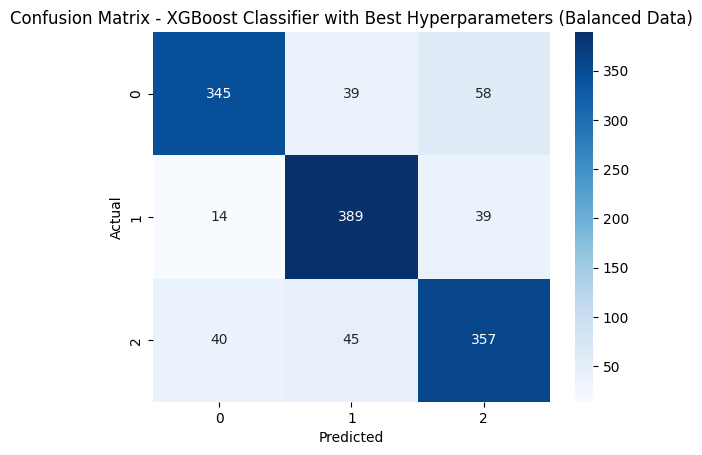

In [44]:
# Get best trial
best_trial = study.best_trials[0]
best_params = best_trial.params

# Train final model with best hyperparameters
final_model = XGBClassifier(random_state=42, **best_params, verbosity=0)
final_model.fit(X_train_bal, y_train_bal)
# Predict
y_pred = final_model.predict(X_test_bal)

# Evaluate
print("XGBoost Classifier Performance on Balanced Test Set with Best Hyperparameters")
print("Macro F1 Score:", f1_score(y_test_bal, y_pred, average='macro'))
print("Macro Precision:", precision_score(y_test_bal, y_pred, average='macro'))
print("Macro Recall:", recall_score(y_test_bal, y_pred, average='macro'))
print("Classification Report:")
print(classification_report(y_test_bal, y_pred))
# Plot confusion matrix
conf_mat = confusion_matrix(y_test_bal, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - XGBoost Classifier with Best Hyperparameters (Balanced Data)')
# Save confusion matrix
plt.savefig('images/confusion_matrix_ht_xgboost_balanced.png', dpi=500)

plt.show()

,Feature,Importance
36,Success_rate_overall,0.149890
35,Success_rate_2nd_sem,0.103028
14,Tuition fees up to date,0.087064
26,Curricular units 2nd sem (enrolled),0.042778
16,Scholarship holder,0.042252
22,Curricular units 1st sem (approved),0.038988
20,Curricular units 1st sem (enrolled),0.036442
28,Curricular units 2nd sem (approved),0.035798
17,Age at enrollment,0.020468
15,Gender,0.019853


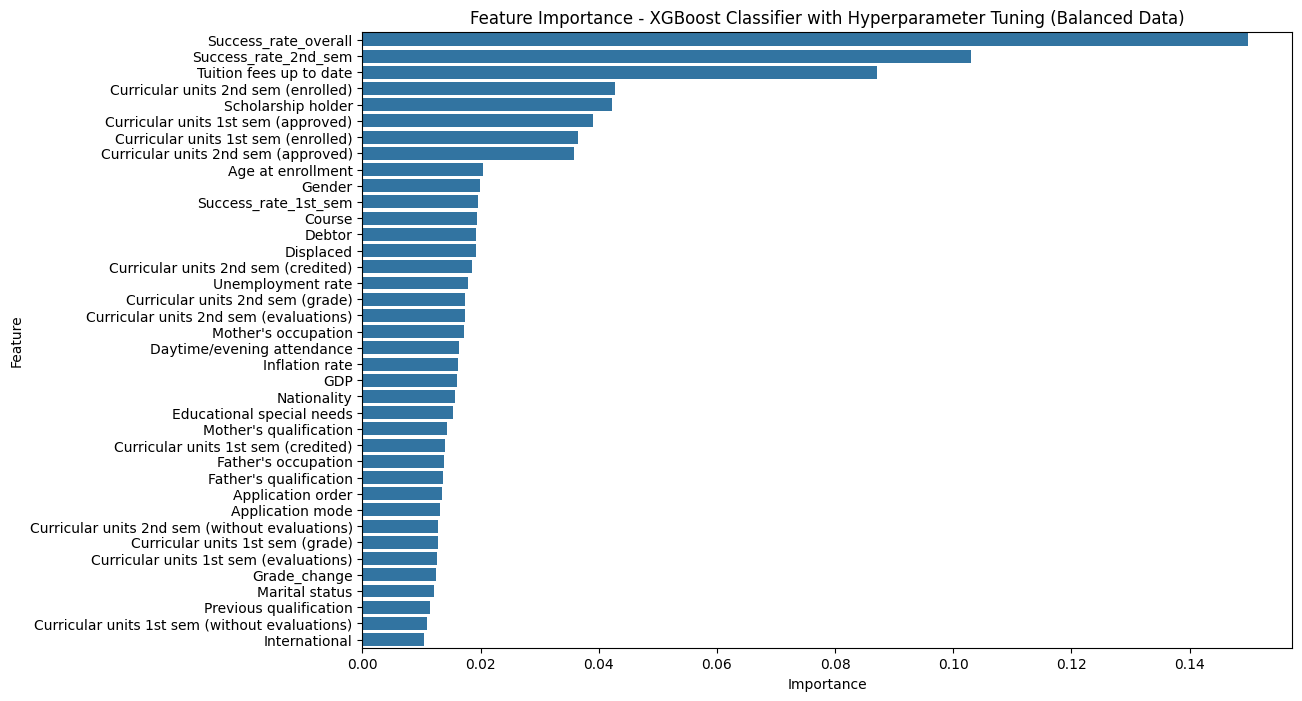

In [45]:
# Check feature importance for XGBoost with hyperparameter tuning on balanced data
importances_xgb_ht_bal = pd.DataFrame({
    'Feature': X_train_bal.columns,
    'Importance': final_model.feature_importances_
})
importances_xgb_ht_bal = importances_xgb_ht_bal.sort_values(by='Importance', ascending=False)
display(importances_xgb_ht_bal)

# Visualize feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importances_xgb_ht_bal)
plt.title('Feature Importance - XGBoost Classifier with Hyperparameter Tuning (Balanced Data)')
# Save feature importance plot
plt.savefig('images/feature_importance_xgboost_ht_balanced.png', dpi=500)

plt.show()

In [46]:
# Create and run study
study = optuna.create_study(directions=['maximize', 'maximize', 'maximize'], study_name='XGBoost Hyperparameter Tuning Multi-Objective (No Enrolled Data)')
start = time.time()
study.optimize(lambda trial: objective(trial, X_train_no_enrolled, y_train_no_enrolled, X_test_no_enrolled, y_test_no_enrolled), n_trials=50)
print(f"Optuna finished in {time.time() - start:.1f}s")

# Show best trials
print("Best trials:")
for i, trial in enumerate(study.best_trials):
    print(f"Trial {i}:")
    print(f"  Value: F1-Score={trial.values[0]:.4f}, Precision={trial.values[1]:.4f}, Recall={trial.values[2]:.4f}")
    print("  Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")

[I 2025-12-07 22:15:54,270] A new study created in memory with name: XGBoost Hyperparameter Tuning Multi-Objective (No Enrolled Data)


Trial 0 finished in 0.1s — F1-Score: 0.9061, Precision: 0.9136, Recall: 0.9005


[I 2025-12-07 22:15:54,466] Trial 0 finished with values: [0.9060718530917207, 0.9135874572255858, 0.9005401185392901] and parameters: {'n_estimators': 419, 'max_depth': 13, 'learning_rate': 0.23741889412735956, 'subsample': 0.5140312069610796, 'colsample_bytree': 0.7815065855346539, 'gamma': 3.2915038963934, 'reg_alpha': 3.2976639289864282, 'reg_lambda': 3.1330555282143675}.


Trial 1 finished in 0.2s — F1-Score: 0.9043, Precision: 0.9140, Recall: 0.8975


[I 2025-12-07 22:15:54,709] Trial 1 finished with values: [0.9042509805194674, 0.913994507728174, 0.8975208718373591] and parameters: {'n_estimators': 391, 'max_depth': 16, 'learning_rate': 0.2923190504350363, 'subsample': 0.8550878461027844, 'colsample_bytree': 0.7439774011975733, 'gamma': 0.37679150874084577, 'reg_alpha': 3.358108064579304, 'reg_lambda': 4.105029085174054}.


Trial 2 finished in 0.2s — F1-Score: 0.8984, Precision: 0.9080, Recall: 0.8917


[I 2025-12-07 22:15:54,944] Trial 2 finished with values: [0.8983587331668192, 0.9079712609824695, 0.8917373016378816] and parameters: {'n_estimators': 324, 'max_depth': 6, 'learning_rate': 0.0963251961038197, 'subsample': 0.9828147406980808, 'colsample_bytree': 0.9751097557054518, 'gamma': 0.6228749063914479, 'reg_alpha': 1.3041849945192097, 'reg_lambda': 3.8618139032955594}.


Trial 3 finished in 0.1s — F1-Score: 0.9133, Precision: 0.9214, Recall: 0.9075


[I 2025-12-07 22:15:55,084] Trial 3 finished with values: [0.9133467525767982, 0.9214312198739341, 0.9074549104582245] and parameters: {'n_estimators': 136, 'max_depth': 6, 'learning_rate': 0.17793543383111193, 'subsample': 0.7201765665253668, 'colsample_bytree': 0.7015034495978743, 'gamma': 2.655533336168027, 'reg_alpha': 2.820304940415394, 'reg_lambda': 1.1984041854194194}.


Trial 4 finished in 0.2s — F1-Score: 0.8967, Precision: 0.9077, Recall: 0.8893


[I 2025-12-07 22:15:55,323] Trial 4 finished with values: [0.8966510212880188, 0.9076638195649273, 0.8893473965967753] and parameters: {'n_estimators': 470, 'max_depth': 7, 'learning_rate': 0.40412552800690127, 'subsample': 0.7129013112240712, 'colsample_bytree': 0.5516749229430091, 'gamma': 2.4113332937840126, 'reg_alpha': 2.7745380005699403, 'reg_lambda': 3.575708969920578}.


Trial 5 finished in 0.2s — F1-Score: 0.8996, Precision: 0.9107, Recall: 0.8922


[I 2025-12-07 22:15:55,560] Trial 5 finished with values: [0.8996038492512182, 0.9106916455358335, 0.892239181696514] and parameters: {'n_estimators': 420, 'max_depth': 15, 'learning_rate': 0.3358059165821164, 'subsample': 0.9753731869630424, 'colsample_bytree': 0.5219693010539297, 'gamma': 0.1871955338011555, 'reg_alpha': 0.6810236325173835, 'reg_lambda': 2.9036562310102276}.


Trial 6 finished in 0.1s — F1-Score: 0.9041, Precision: 0.9148, Recall: 0.8969


[I 2025-12-07 22:15:55,773] Trial 6 finished with values: [0.9041062208015737, 0.9148120394654677, 0.8968915301765343] and parameters: {'n_estimators': 453, 'max_depth': 9, 'learning_rate': 0.40775677416187445, 'subsample': 0.8071124094025992, 'colsample_bytree': 0.7934338229604454, 'gamma': 3.040462398120294, 'reg_alpha': 3.9542422532162758, 'reg_lambda': 0.35275244675741946}.


Trial 7 finished in 0.1s — F1-Score: 0.9063, Precision: 0.9122, Recall: 0.9018


[I 2025-12-07 22:15:55,945] Trial 7 finished with values: [0.9063414634146342, 0.9122016999019287, 0.9017988018609393] and parameters: {'n_estimators': 299, 'max_depth': 15, 'learning_rate': 0.33394664151995324, 'subsample': 0.9511997405537941, 'colsample_bytree': 0.7551059340730228, 'gamma': 4.776508463834718, 'reg_alpha': 2.113267992839487, 'reg_lambda': 2.7014800937582657}.


Trial 8 finished in 0.2s — F1-Score: 0.9085, Precision: 0.9198, Recall: 0.9009


[I 2025-12-07 22:15:56,188] Trial 8 finished with values: [0.9084623331408166, 0.9197751234485521, 0.9009145369957301] and parameters: {'n_estimators': 437, 'max_depth': 11, 'learning_rate': 0.050121667562921385, 'subsample': 0.9277355341826319, 'colsample_bytree': 0.592581027793003, 'gamma': 2.527634537306234, 'reg_alpha': 4.305906625284558, 'reg_lambda': 0.8771686253359945}.


Trial 9 finished in 0.1s — F1-Score: 0.9001, Precision: 0.9083, Recall: 0.8941


[I 2025-12-07 22:15:56,372] Trial 9 finished with values: [0.9000550660792952, 0.908336084516342, 0.8941272066789879] and parameters: {'n_estimators': 186, 'max_depth': 14, 'learning_rate': 0.2620741058785029, 'subsample': 0.7674120370497033, 'colsample_bytree': 0.6774207533000507, 'gamma': 1.9413452865333007, 'reg_alpha': 1.6184981944871808, 'reg_lambda': 1.7212069614002379}.


Trial 10 finished in 0.1s — F1-Score: 0.9030, Precision: 0.9113, Recall: 0.8970


[I 2025-12-07 22:15:56,555] Trial 10 finished with values: [0.9029946229593159, 0.9113321228128095, 0.8970189917787266] and parameters: {'n_estimators': 338, 'max_depth': 5, 'learning_rate': 0.4456170670721609, 'subsample': 0.6161619912731875, 'colsample_bytree': 0.6418550509993678, 'gamma': 4.110733186724225, 'reg_alpha': 1.9966154889308363, 'reg_lambda': 2.4533425220425107}.


Trial 11 finished in 0.1s — F1-Score: 0.9016, Precision: 0.9095, Recall: 0.8959


[I 2025-12-07 22:15:56,780] Trial 11 finished with values: [0.9015971597058556, 0.9094673093560746, 0.8958877700592696] and parameters: {'n_estimators': 447, 'max_depth': 15, 'learning_rate': 0.4812826712802949, 'subsample': 0.8379083577133176, 'colsample_bytree': 0.736098686582304, 'gamma': 1.6081911185182025, 'reg_alpha': 1.9368217293641676, 'reg_lambda': 3.282200391848204}.


Trial 12 finished in 0.1s — F1-Score: 0.9016, Precision: 0.9095, Recall: 0.8959


[I 2025-12-07 22:15:56,987] Trial 12 finished with values: [0.9015971597058556, 0.9094673093560746, 0.8958877700592696] and parameters: {'n_estimators': 389, 'max_depth': 11, 'learning_rate': 0.2943144260248919, 'subsample': 0.6286404282649829, 'colsample_bytree': 0.9978442613447649, 'gamma': 2.7442511021246405, 'reg_alpha': 3.1207989807147296, 'reg_lambda': 0.4042481729177605}.


Trial 13 finished in 0.2s — F1-Score: 0.8970, Precision: 0.9061, Recall: 0.8906


[I 2025-12-07 22:15:57,228] Trial 13 finished with values: [0.896962815782004, 0.90608228980322, 0.8906060799184246] and parameters: {'n_estimators': 248, 'max_depth': 12, 'learning_rate': 0.37149564392627954, 'subsample': 0.8591913633849195, 'colsample_bytree': 0.6697604261126033, 'gamma': 0.16721735421121098, 'reg_alpha': 0.5204363209611196, 'reg_lambda': 2.9287596935427795}.


Trial 14 finished in 0.1s — F1-Score: 0.9017, Precision: 0.9088, Recall: 0.8965


[I 2025-12-07 22:15:57,402] Trial 14 finished with values: [0.9017402809902331, 0.9087575655544515, 0.8965171117200943] and parameters: {'n_estimators': 325, 'max_depth': 12, 'learning_rate': 0.29917358382172676, 'subsample': 0.7866851081009494, 'colsample_bytree': 0.642388178820719, 'gamma': 3.351631299956097, 'reg_alpha': 2.504984967565711, 'reg_lambda': 3.550165025652459}.


Trial 15 finished in 0.2s — F1-Score: 0.9100, Precision: 0.9209, Recall: 0.9027


[I 2025-12-07 22:15:57,682] Trial 15 finished with values: [0.9100073764445538, 0.9208567503434495, 0.9026751003760117] and parameters: {'n_estimators': 466, 'max_depth': 13, 'learning_rate': 0.10748482348101712, 'subsample': 0.7446113703523836, 'colsample_bytree': 0.9666300569843298, 'gamma': 2.0557127526906926, 'reg_alpha': 4.571086166200145, 'reg_lambda': 4.510387278666409}.


Trial 16 finished in 0.1s — F1-Score: 0.9034, Precision: 0.9092, Recall: 0.8989


[I 2025-12-07 22:15:57,877] Trial 16 finished with values: [0.9034146341463415, 0.9092350441320693, 0.8989070167612007] and parameters: {'n_estimators': 313, 'max_depth': 20, 'learning_rate': 0.20449987920007584, 'subsample': 0.663507773700825, 'colsample_bytree': 0.5866167754977298, 'gamma': 3.863522619991511, 'reg_alpha': 2.3304160339487656, 'reg_lambda': 2.324638054867914}.


Trial 17 finished in 0.1s — F1-Score: 0.9043, Precision: 0.9140, Recall: 0.8975


[I 2025-12-07 22:15:58,056] Trial 17 finished with values: [0.9042509805194674, 0.913994507728174, 0.8975208718373591] and parameters: {'n_estimators': 260, 'max_depth': 17, 'learning_rate': 0.130619099418385, 'subsample': 0.7478778755567685, 'colsample_bytree': 0.5042286259428617, 'gamma': 3.257287622465847, 'reg_alpha': 1.4514497874089511, 'reg_lambda': 4.9156471221838265}.


Trial 18 finished in 0.1s — F1-Score: 0.9114, Precision: 0.9228, Recall: 0.9038


[I 2025-12-07 22:15:58,254] Trial 18 finished with values: [0.911415161104016, 0.9228029494194582, 0.9038063220954687] and parameters: {'n_estimators': 291, 'max_depth': 3, 'learning_rate': 0.08819829314915395, 'subsample': 0.63173928689496, 'colsample_bytree': 0.6677163490776197, 'gamma': 1.497481733109759, 'reg_alpha': 3.518429462067318, 'reg_lambda': 3.8970379257997756}.


Trial 19 finished in 0.1s — F1-Score: 0.9001, Precision: 0.9083, Recall: 0.8941


[I 2025-12-07 22:15:58,400] Trial 19 finished with values: [0.9000550660792952, 0.908336084516342, 0.8941272066789879] and parameters: {'n_estimators': 189, 'max_depth': 5, 'learning_rate': 0.48410692726690524, 'subsample': 0.6345155256121922, 'colsample_bytree': 0.5441379439759774, 'gamma': 3.528506919482615, 'reg_alpha': 1.3705273430465188, 'reg_lambda': 1.9400575962768207}.


Trial 20 finished in 0.1s — F1-Score: 0.9121, Precision: 0.9188, Recall: 0.9070


[I 2025-12-07 22:15:58,623] Trial 20 finished with values: [0.9120696337445902, 0.9188311688311688, 0.9069530303995921] and parameters: {'n_estimators': 481, 'max_depth': 5, 'learning_rate': 0.4331983591976446, 'subsample': 0.9966720125193503, 'colsample_bytree': 0.8347425068728658, 'gamma': 2.6503978103248667, 'reg_alpha': 2.8355761823342656, 'reg_lambda': 3.319180372653174}.


Trial 21 finished in 0.1s — F1-Score: 0.9069, Precision: 0.9187, Recall: 0.8992


[I 2025-12-07 22:15:58,844] Trial 21 finished with values: [0.9069145526147082, 0.9186965713760455, 0.8991539736154484] and parameters: {'n_estimators': 339, 'max_depth': 13, 'learning_rate': 0.13379581728612108, 'subsample': 0.5715861159478741, 'colsample_bytree': 0.5205787759156628, 'gamma': 2.282017716834532, 'reg_alpha': 0.6859833026424778, 'reg_lambda': 3.760310259440872}.


Trial 22 finished in 0.1s — F1-Score: 0.8967, Precision: 0.9077, Recall: 0.8893


[I 2025-12-07 22:15:59,012] Trial 22 finished with values: [0.8966510212880188, 0.9076638195649273, 0.8893473965967753] and parameters: {'n_estimators': 276, 'max_depth': 4, 'learning_rate': 0.2796105982468564, 'subsample': 0.8823586347867403, 'colsample_bytree': 0.9264150833691832, 'gamma': 2.8904815819252416, 'reg_alpha': 0.1294459438205997, 'reg_lambda': 0.7166819230029764}.


Trial 23 finished in 0.1s — F1-Score: 0.9040, Precision: 0.9157, Recall: 0.8963


[I 2025-12-07 22:15:59,180] Trial 23 finished with values: [0.9039594590469213, 0.9156632043386341, 0.8962621885157096] and parameters: {'n_estimators': 281, 'max_depth': 7, 'learning_rate': 0.4113776658031585, 'subsample': 0.5438758301554132, 'colsample_bytree': 0.5433019630418147, 'gamma': 3.655722570791639, 'reg_alpha': 2.787784806468111, 'reg_lambda': 0.003693232717696948}.


Trial 24 finished in 0.1s — F1-Score: 0.9101, Precision: 0.9200, Recall: 0.9033


[I 2025-12-07 22:15:59,360] Trial 24 finished with values: [0.9101432278721155, 0.9200177544738786, 0.9033044420368364] and parameters: {'n_estimators': 226, 'max_depth': 4, 'learning_rate': 0.08439924419258574, 'subsample': 0.7394203958959463, 'colsample_bytree': 0.7683830349774341, 'gamma': 3.1798872278830768, 'reg_alpha': 0.06422178748783092, 'reg_lambda': 2.3387865514352555}.


Trial 25 finished in 0.1s — F1-Score: 0.9055, Precision: 0.9167, Recall: 0.8980


[I 2025-12-07 22:15:59,546] Trial 25 finished with values: [0.905509505177617, 0.9167472974776458, 0.8980227518959913] and parameters: {'n_estimators': 349, 'max_depth': 12, 'learning_rate': 0.34848827757162026, 'subsample': 0.7315418531283944, 'colsample_bytree': 0.6579278828646202, 'gamma': 3.384843262027812, 'reg_alpha': 1.2058412816962512, 'reg_lambda': 3.725774116505407}.


Trial 26 finished in 0.1s — F1-Score: 0.9104, Precision: 0.9184, Recall: 0.9046


[I 2025-12-07 22:15:59,699] Trial 26 finished with values: [0.9104093543590626, 0.9184402422444692, 0.9045631253584858] and parameters: {'n_estimators': 155, 'max_depth': 5, 'learning_rate': 0.18227905362528007, 'subsample': 0.6089666922031446, 'colsample_bytree': 0.8818161652871118, 'gamma': 2.4887504568800227, 'reg_alpha': 2.9814828645616958, 'reg_lambda': 4.144186938456344}.


Trial 27 finished in 0.0s — F1-Score: 0.9085, Precision: 0.9198, Recall: 0.9009


[I 2025-12-07 22:15:59,820] Trial 27 finished with values: [0.9084623331408166, 0.9197751234485521, 0.9009145369957301] and parameters: {'n_estimators': 51, 'max_depth': 18, 'learning_rate': 0.14831247060459637, 'subsample': 0.7797993870370794, 'colsample_bytree': 0.7856018979099153, 'gamma': 3.608811457733156, 'reg_alpha': 1.4859923392676038, 'reg_lambda': 4.725724704689164}.


Trial 28 finished in 0.1s — F1-Score: 0.8967, Precision: 0.9077, Recall: 0.8893


[I 2025-12-07 22:15:59,972] Trial 28 finished with values: [0.8966510212880188, 0.9076638195649273, 0.8893473965967753] and parameters: {'n_estimators': 90, 'max_depth': 12, 'learning_rate': 0.16370191412247345, 'subsample': 0.5596376771945543, 'colsample_bytree': 0.7707045059894024, 'gamma': 1.5294721527169108, 'reg_alpha': 0.5661225367569522, 'reg_lambda': 1.2294614757824152}.


Trial 29 finished in 0.1s — F1-Score: 0.9027, Precision: 0.9129, Recall: 0.8958


[I 2025-12-07 22:16:00,148] Trial 29 finished with values: [0.9027046783625732, 0.912890625, 0.8957603084570773] and parameters: {'n_estimators': 193, 'max_depth': 6, 'learning_rate': 0.32547754539908375, 'subsample': 0.7600480601875224, 'colsample_bytree': 0.6629231954536372, 'gamma': 0.9250013210033398, 'reg_alpha': 3.797464053862058, 'reg_lambda': 4.3462208204902435}.


Trial 30 finished in 0.1s — F1-Score: 0.9043, Precision: 0.9140, Recall: 0.8975


[I 2025-12-07 22:16:00,325] Trial 30 finished with values: [0.9042509805194674, 0.913994507728174, 0.8975208718373591] and parameters: {'n_estimators': 329, 'max_depth': 4, 'learning_rate': 0.4350328791662604, 'subsample': 0.8389646625225953, 'colsample_bytree': 0.7297968888685411, 'gamma': 2.0868381102764495, 'reg_alpha': 3.4739525778308074, 'reg_lambda': 1.1405265907767226}.


Trial 31 finished in 0.1s — F1-Score: 0.9043, Precision: 0.9140, Recall: 0.8975


[I 2025-12-07 22:16:00,469] Trial 31 finished with values: [0.9042509805194674, 0.913994507728174, 0.8975208718373591] and parameters: {'n_estimators': 156, 'max_depth': 6, 'learning_rate': 0.2874219013669067, 'subsample': 0.9245402876117452, 'colsample_bytree': 0.6593128090130178, 'gamma': 2.1065374035776845, 'reg_alpha': 3.1141135476502537, 'reg_lambda': 0.13709042106974323}.


Trial 32 finished in 0.2s — F1-Score: 0.9062, Precision: 0.9129, Recall: 0.9012


[I 2025-12-07 22:16:00,704] Trial 32 finished with values: [0.9062076093275628, 0.9128787878787878, 0.9011694602001147] and parameters: {'n_estimators': 496, 'max_depth': 7, 'learning_rate': 0.19801329624219605, 'subsample': 0.5438663970688622, 'colsample_bytree': 0.5420872877301826, 'gamma': 4.8445607030681845, 'reg_alpha': 3.5890059870503204, 'reg_lambda': 0.2852711564346794}.


Trial 33 finished in 0.1s — F1-Score: 0.9027, Precision: 0.9129, Recall: 0.8958


[I 2025-12-07 22:16:00,913] Trial 33 finished with values: [0.9027046783625732, 0.912890625, 0.8957603084570773] and parameters: {'n_estimators': 150, 'max_depth': 15, 'learning_rate': 0.17251375337761635, 'subsample': 0.5434801705911692, 'colsample_bytree': 0.6452651411435135, 'gamma': 0.2983852183404412, 'reg_alpha': 4.112231018226264, 'reg_lambda': 1.580895404254149}.


Trial 34 finished in 0.1s — F1-Score: 0.9040, Precision: 0.9157, Recall: 0.8963


[I 2025-12-07 22:16:01,085] Trial 34 finished with values: [0.9039594590469213, 0.9156632043386341, 0.8962621885157096] and parameters: {'n_estimators': 179, 'max_depth': 4, 'learning_rate': 0.3380017619218313, 'subsample': 0.8144387060208486, 'colsample_bytree': 0.7719640111448374, 'gamma': 0.6479331513563952, 'reg_alpha': 0.9926494082341192, 'reg_lambda': 2.7734689377513932}.


Trial 35 finished in 0.1s — F1-Score: 0.8911, Precision: 0.9001, Recall: 0.8848


[I 2025-12-07 22:16:01,214] Trial 35 finished with values: [0.8910749766838327, 0.9000695686742198, 0.8848225097189472] and parameters: {'n_estimators': 56, 'max_depth': 4, 'learning_rate': 0.4961910693471068, 'subsample': 0.7883567543176113, 'colsample_bytree': 0.7368237167661211, 'gamma': 0.5815366004027978, 'reg_alpha': 1.420740885975738, 'reg_lambda': 1.3098463011673467}.


Trial 36 finished in 0.1s — F1-Score: 0.9002, Precision: 0.9076, Recall: 0.8948


[I 2025-12-07 22:16:01,375] Trial 36 finished with values: [0.9002013439099532, 0.9076154909186629, 0.8947565483398126] and parameters: {'n_estimators': 191, 'max_depth': 7, 'learning_rate': 0.09998745569480463, 'subsample': 0.5293614801540338, 'colsample_bytree': 0.638690852702742, 'gamma': 3.692491916940127, 'reg_alpha': 0.821897596744377, 'reg_lambda': 3.596811995295104}.


Trial 37 finished in 0.1s — F1-Score: 0.9003, Precision: 0.9069, Recall: 0.8954


[I 2025-12-07 22:16:01,564] Trial 37 finished with values: [0.9003455849105355, 0.9069264069264069, 0.8953858900006373] and parameters: {'n_estimators': 182, 'max_depth': 6, 'learning_rate': 0.41557667490661704, 'subsample': 0.5819110379133337, 'colsample_bytree': 0.7577450062229834, 'gamma': 1.939840687894655, 'reg_alpha': 1.720971133183404, 'reg_lambda': 4.643167468771422}.


Trial 38 finished in 0.1s — F1-Score: 0.8998, Precision: 0.9099, Recall: 0.8929


[I 2025-12-07 22:16:01,706] Trial 38 finished with values: [0.8997563352826511, 0.9098736702127659, 0.8928685233573386] and parameters: {'n_estimators': 64, 'max_depth': 12, 'learning_rate': 0.14794098898470043, 'subsample': 0.5991433203057246, 'colsample_bytree': 0.9936875800000162, 'gamma': 0.5219019466344971, 'reg_alpha': 4.7463231139821085, 'reg_lambda': 0.6416852652984167}.


Trial 39 finished in 0.1s — F1-Score: 0.9027, Precision: 0.9129, Recall: 0.8958


[I 2025-12-07 22:16:01,853] Trial 39 finished with values: [0.9027046783625732, 0.912890625, 0.8957603084570773] and parameters: {'n_estimators': 168, 'max_depth': 20, 'learning_rate': 0.36018756216286485, 'subsample': 0.9630651656965417, 'colsample_bytree': 0.995983788686188, 'gamma': 2.4008010022160606, 'reg_alpha': 1.8406558641017563, 'reg_lambda': 4.968785670468129}.


Trial 40 finished in 0.1s — F1-Score: 0.9012, Precision: 0.9118, Recall: 0.8940


[I 2025-12-07 22:16:01,979] Trial 40 finished with values: [0.9011556429800835, 0.9117896840264769, 0.8939997450767956] and parameters: {'n_estimators': 89, 'max_depth': 12, 'learning_rate': 0.2764951733179719, 'subsample': 0.5776074756980717, 'colsample_bytree': 0.506021001627678, 'gamma': 3.71522191603801, 'reg_alpha': 0.9048542349026262, 'reg_lambda': 2.385266366348255}.


Trial 41 finished in 0.1s — F1-Score: 0.9058, Precision: 0.9151, Recall: 0.8993


[I 2025-12-07 22:16:02,154] Trial 41 finished with values: [0.9057945744292608, 0.9151013714967203, 0.8992814352176407] and parameters: {'n_estimators': 349, 'max_depth': 20, 'learning_rate': 0.45188756910765915, 'subsample': 0.976520472437229, 'colsample_bytree': 0.853602779254506, 'gamma': 3.703731426290572, 'reg_alpha': 1.9352744744478785, 'reg_lambda': 2.892245460811117}.


Trial 42 finished in 0.2s — F1-Score: 0.9059, Precision: 0.9143, Recall: 0.8999


[I 2025-12-07 22:16:02,386] Trial 42 finished with values: [0.9059341798393366, 0.9143281611092771, 0.8999107768784653] and parameters: {'n_estimators': 475, 'max_depth': 3, 'learning_rate': 0.10795845695254025, 'subsample': 0.726196828065249, 'colsample_bytree': 0.9371738123367293, 'gamma': 2.039944088531127, 'reg_alpha': 2.5463897649205265, 'reg_lambda': 3.845300425745779}.


Trial 43 finished in 0.1s — F1-Score: 0.9071, Precision: 0.9178, Recall: 0.8998


[I 2025-12-07 22:16:02,611] Trial 43 finished with values: [0.9070567986230637, 0.9178343949044586, 0.8997833152762731] and parameters: {'n_estimators': 454, 'max_depth': 9, 'learning_rate': 0.10678305008851, 'subsample': 0.7289925327656321, 'colsample_bytree': 0.706969808305856, 'gamma': 3.5898616300869923, 'reg_alpha': 2.293920199128003, 'reg_lambda': 1.197287102592373}.


Trial 44 finished in 0.1s — F1-Score: 0.9041, Precision: 0.9148, Recall: 0.8969


[I 2025-12-07 22:16:02,794] Trial 44 finished with values: [0.9041062208015737, 0.9148120394654677, 0.8968915301765343] and parameters: {'n_estimators': 187, 'max_depth': 20, 'learning_rate': 0.1303715536382359, 'subsample': 0.7042208413371773, 'colsample_bytree': 0.9463456547581098, 'gamma': 2.0690538907654332, 'reg_alpha': 0.7739237761818674, 'reg_lambda': 3.3719715503058216}.


Trial 45 finished in 0.1s — F1-Score: 0.9072, Precision: 0.9170, Recall: 0.9004


[I 2025-12-07 22:16:03,003] Trial 45 finished with values: [0.9071971041957914, 0.9170061311010262, 0.9004126569370977] and parameters: {'n_estimators': 440, 'max_depth': 3, 'learning_rate': 0.20057256305781063, 'subsample': 0.9061881452301193, 'colsample_bytree': 0.8742382097690563, 'gamma': 3.584307184137711, 'reg_alpha': 2.2968175138788642, 'reg_lambda': 4.169991152278732}.


Trial 46 finished in 0.1s — F1-Score: 0.9066, Precision: 0.9205, Recall: 0.8979


[I 2025-12-07 22:16:03,183] Trial 46 finished with values: [0.906624175474198, 0.920524866762648, 0.897895290293799] and parameters: {'n_estimators': 330, 'max_depth': 9, 'learning_rate': 0.4749279316655671, 'subsample': 0.9732964665619451, 'colsample_bytree': 0.8800522678196023, 'gamma': 4.496562757252317, 'reg_alpha': 0.6519654765544919, 'reg_lambda': 1.4528575947973095}.


Trial 47 finished in 0.2s — F1-Score: 0.9118, Precision: 0.9203, Recall: 0.9057


[I 2025-12-07 22:16:03,414] Trial 47 finished with values: [0.9118132935993781, 0.9203202377022119, 0.9056943470779428] and parameters: {'n_estimators': 485, 'max_depth': 6, 'learning_rate': 0.1760370983969034, 'subsample': 0.643434261291886, 'colsample_bytree': 0.8069661276772917, 'gamma': 2.484900033933746, 'reg_alpha': 4.222671474732508, 'reg_lambda': 1.195753216970585}.


Trial 48 finished in 0.1s — F1-Score: 0.9034, Precision: 0.9092, Recall: 0.8989


[I 2025-12-07 22:16:03,572] Trial 48 finished with values: [0.9034146341463415, 0.9092350441320693, 0.8989070167612007] and parameters: {'n_estimators': 214, 'max_depth': 20, 'learning_rate': 0.3322474452755676, 'subsample': 0.8304377067988802, 'colsample_bytree': 0.5749856974647216, 'gamma': 3.957653776946151, 'reg_alpha': 4.779172091800375, 'reg_lambda': 0.5495752178592794}.


Trial 49 finished in 0.2s — F1-Score: 0.8886, Precision: 0.8950, Recall: 0.8838


[I 2025-12-07 22:16:03,856] Trial 49 finished with values: [0.8886215360764809, 0.895021645021645, 0.8838187496016825] and parameters: {'n_estimators': 454, 'max_depth': 10, 'learning_rate': 0.48457455483640194, 'subsample': 0.5533150410951964, 'colsample_bytree': 0.7767797310160708, 'gamma': 0.35202909269740235, 'reg_alpha': 0.9313790314675785, 'reg_lambda': 0.7985322444600668}.


Optuna finished in 9.6s
Best trials:
Trial 0:
  Value: F1-Score=0.9133, Precision=0.9214, Recall=0.9075
  Params: 
    n_estimators: 136
    max_depth: 6
    learning_rate: 0.17793543383111193
    subsample: 0.7201765665253668
    colsample_bytree: 0.7015034495978743
    gamma: 2.655533336168027
    reg_alpha: 2.820304940415394
    reg_lambda: 1.1984041854194194
Trial 1:
  Value: F1-Score=0.9114, Precision=0.9228, Recall=0.9038
  Params: 
    n_estimators: 291
    max_depth: 3
    learning_rate: 0.08819829314915395
    subsample: 0.63173928689496
    colsample_bytree: 0.6677163490776197
    gamma: 1.497481733109759
    reg_alpha: 3.518429462067318
    reg_lambda: 3.8970379257997756


XGBoost Classifier Performance on No Enrolled Test Set with Best Hyperparameters
Macro F1 Score: 0.9133467525767982
Macro Precision: 0.9214312198739341
Macro Recall: 0.9074549104582245
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.86      0.89       284
           1       0.91      0.96      0.93       442

    accuracy                           0.92       726
   macro avg       0.92      0.91      0.91       726
weighted avg       0.92      0.92      0.92       726



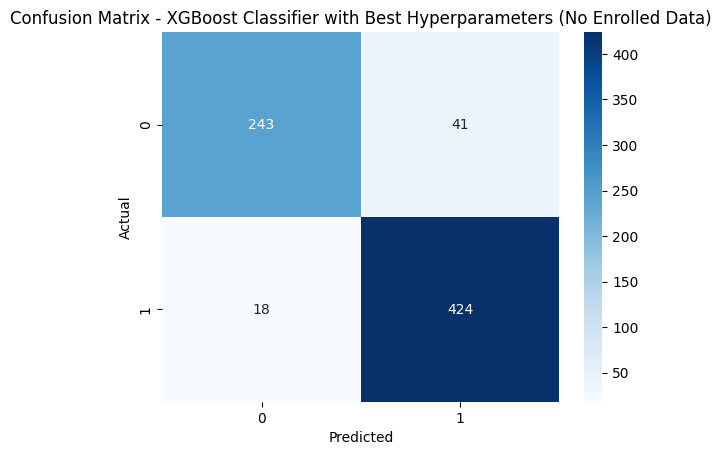

In [47]:
# Get best trial
best_trial = study.best_trials[0]
best_params = best_trial.params

# Train final model with best hyperparameters
final_model = XGBClassifier(random_state=42, **best_params, verbosity=0)
final_model.fit(X_train_no_enrolled, y_train_no_enrolled)
# Predict
y_pred = final_model.predict(X_test_no_enrolled)

# Evaluate
print("XGBoost Classifier Performance on No Enrolled Test Set with Best Hyperparameters")
print("Macro F1 Score:", f1_score(y_test_no_enrolled, y_pred, average='macro'))
print("Macro Precision:", precision_score(y_test_no_enrolled, y_pred, average='macro'))
print("Macro Recall:", recall_score(y_test_no_enrolled, y_pred, average='macro'))
print("Classification Report:")
print(classification_report(y_test_no_enrolled, y_pred))
# Plot confusion matrix
conf_mat = confusion_matrix(y_test_no_enrolled, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - XGBoost Classifier with Best Hyperparameters (No Enrolled Data)')
# Save confusion matrix
plt.savefig('images/confusion_matrix_xgboost_ht_no_enrolled.png', dpi=500)

plt.show()

,Feature,Importance
36,Success_rate_overall,0.325656
35,Success_rate_2nd_sem,0.154796
28,Curricular units 2nd sem (approved),0.112761
14,Tuition fees up to date,0.044406
20,Curricular units 1st sem (enrolled),0.039289
34,Success_rate_1st_sem,0.028703
26,Curricular units 2nd sem (enrolled),0.025912
13,Debtor,0.023960
16,Scholarship holder,0.015009
3,Course,0.013700


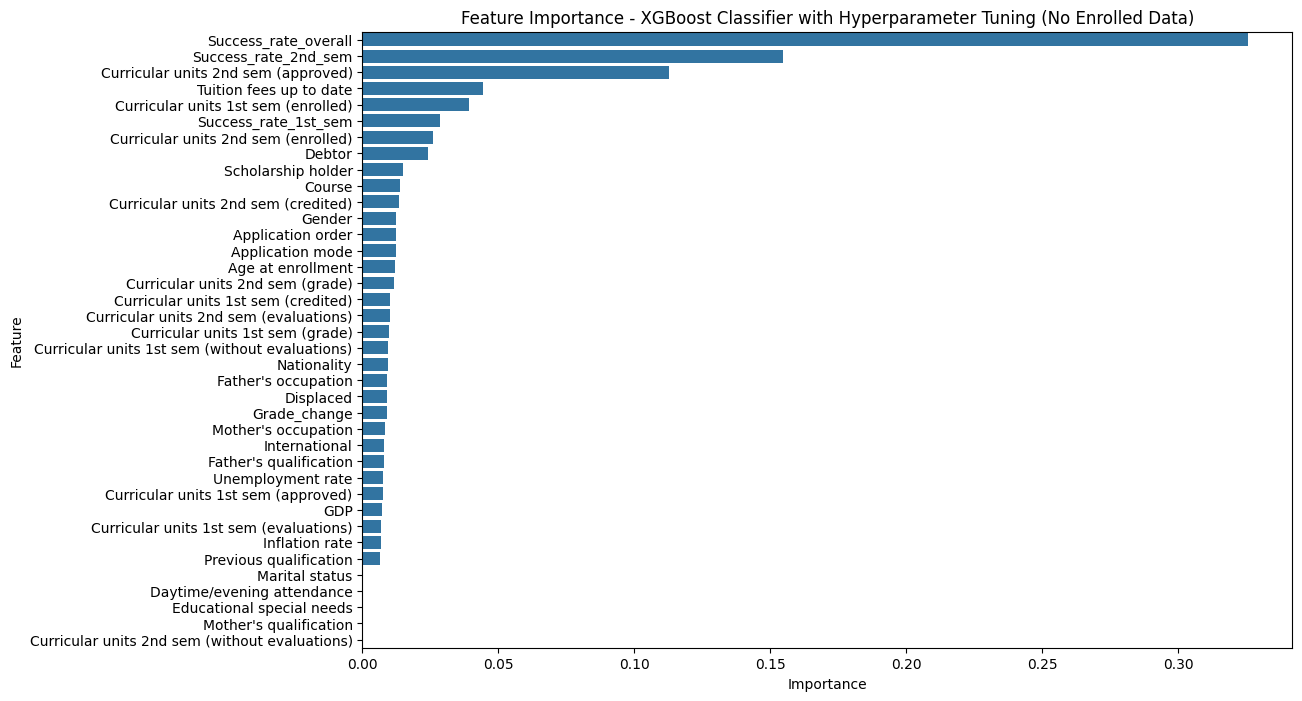

In [48]:
# Check feature importance for XGBoost with hyperparameter tuning on no enrolled data
importances_xgb_no_enrolled_ht = pd.DataFrame({
    'Feature': X_train_no_enrolled.columns,
    'Importance': final_model.feature_importances_
})
importances_xgb_no_enrolled_ht = importances_xgb_no_enrolled_ht.sort_values(by='Importance', ascending=False)
display(importances_xgb_no_enrolled_ht)

# Visualize feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importances_xgb_no_enrolled_ht)
plt.title('Feature Importance - XGBoost Classifier with Hyperparameter Tuning (No Enrolled Data)')
# Save feature importance plot
plt.savefig('images/feature_importance_xgboost_no_enrolled_ht.png', dpi=500)

plt.show()